In [1]:
##
## Packages
##

import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np
import os
import specutils.io
from specutils.io import read_fits
from specutils.io.read_fits import FITSWCSError
from specutils.io import write_fits
from astropy import units as U
from astropy import constants as C
from astropy.modeling import models, fitting
from astroquery.nist import Nist
from datetime import datetime
import astropy.io.ascii as asciitable
import re
import random



##
## Functions
##

def file():
    files = sorted(os.listdir())

    file = []

    for specs in files:
        if specs.endswith('.fits'):
            file.append(specs)
    
    return file


def filelist():
    for i in range(len(file())):
        print(i,':', file()[i])


def wavelength_and_flux(filename, xmin, xmax, ymin, ymax, doplot=True, doplot_all=False):
    
    try:
        spec = read_fits.read_fits_spectrum1d(filename, dispersion_unit=U.Angstrom, flux_unit=U.erg/U.cm**2/U.s/U.Angstrom)
        wavelength = spec.dispersion
        flux = spec.flux
    except FITSWCSError:
        spec = fits.open(filename)
        wavelength = []
        for i in range(len(spec[0].data[0])):
                wavelength += [float(i*(spec[0].header['CDELT1'])+(spec[0].header['CRVAL1']))]
        flux = spec[0].data[1]

    try:
        wavelength = wavelength.value
    except AttributeError:
        wavelength = wavelength

    try:
        flux = flux.value
    except AttributeError:
        flux = flux
    
    if doplot is True:
        plt.figure(figsize=(20,10))
        plt.xlabel('Wavelength (Angstrom)')
        plt.ylabel('Flux (erg/cm$^2$/s/Angstrom)')
        plt.title(filename)
        plt.plot(wavelength,flux)
        plt.xlim(xmin,xmax)
        plt.ylim(ymin,ymax)
        plt.show()

    if doplot_all is True:
        for i in range(len(file())):
            plt.figure(figsize=(20,10))
            plt.xlabel('Wavelength (Angstrom)')
            plt.ylabel('Flux (erg/cm$^2$/s/Angstrom)')
            plt.title(file()[i])
            plt.plot(read_fits.read_fits_spectrum1d(file()[i], dispersion_unit=U.Angstrom, flux_unit=U.erg/U.cm**2/U.s/U.Angstrom).dispersion,
                     read_fits.read_fits_spectrum1d(file()[i], dispersion_unit=U.Angstrom, flux_unit=U.erg/U.cm**2/U.s/U.Angstrom).flux)
            plt.xlim(xmin,xmax)
            plt.ylim(ymin,ymax)
            plt.show()
    
    return wavelength, flux

def wavelength_2D_and_flux_2D(filename, xmin, xmax, ymin, ymax, doplot=True):
    spec = fits.open(''+filename+'')

    flux_summed = []
    
    for i in range(len(spec[0].data)):
        flux_summed += [(sum(spec[0].data[i][int(len(spec[0].data[i])/3):int((len(spec[0].data[i])/3)*2)]),i)]


    slice_num = sorted(flux_summed,reverse=True)[0][1]

    wavelength = []
    for i in range(len(spec[0].data[slice_num])):
        wavelength += [round(float(i*(spec[0].header['CDELT1']*10.)+(spec[0].header['CRVAL1']*10.)),5)]

    wavelength = np.array(wavelength)
        
    flux = np.array(spec[0].data[slice_num])

    if doplot is True:
        plt.figure(figsize=(20,10))
        plt.xlabel('Wavelength (Angstrom)')
        plt.ylabel('Flux (erg/cm$^2$/s/Angstrom)')
        plt.title(filename)
        plt.plot(wavelength,flux)
        plt.xlim(xmin,xmax)
        plt.ylim(ymin,ymax)
        plt.show()
    return wavelength, flux

def gaussian(x, 
             height1, center1, width1, 
             offset):
    
    gauss1 = -height1*np.exp(-(x - center1)**2/(2*width1**2)) + offset
    
    return gauss1


def gaussian2(x, 
              height1, center1, width1, 
              height2, center2, width2, 
              offset):
    
    gauss2 = ((gaussian(x, height1, center1, width1, offset=0) + gaussian(x, height2, center2, width2, offset=0)) + offset)
    
    return gauss2


def gaussian3(x, 
              height1, center1, width1, 
              height2, center2, width2, 
              height3, center3, width3, 
              offset):
    
    gauss3 = ((gaussian(x, height1, center1, width1, offset=0)\
               + gaussian(x, height2, center2, width2, offset=0)\
               + gaussian(x, height3, center3, width3, offset=0)) + offset)
    
    return gauss3


def gaussian4(x, 
              height1, center1, width1, 
              height2, center2, width2, 
              height3, center3, width3, 
              height4, center4, width4, 
              offset):
    
    gauss4 = ((gaussian(x, height1, center1, width1, offset=0)\
               + gaussian(x, height2, center2, width2, offset=0)\
               + gaussian(x, height3, center3, width3, offset=0)\
               + gaussian(x, height4, center4, width4, offset=0)) + offset)
    
    return gauss4


def doppler_velocity(filename, wavelength, flux, feature, feature_wavelength, feature_min, feature_max, height, center, width, offset=1, temp_continuum=1, doshift=False, save_doppler=False):

    
    try:
        wavelength = wavelength.value
    except AttributeError:
        wavelength = wavelength

    try:
        flux = flux.value
    except AttributeError:
        flux = flux
            
    feature_selected = feature_selection(wavelength, flux, feature_wavelength, feature_min, feature_max, temp_continuum=temp_continuum)

    
    print('' + str(feature) + ' - Original')
    height, center, width, gauss_steps = gauss_guessing(feature_selected, 
                                                        offset, wavelength, flux,
                                                        height1=height, center1=center, width1=width, 
                                                        height2=None, center2=None, width2=None, 
                                                        height3=None, center3=None, width3=None, 
                                                        height4=None, center4=None, width4=None, 
                                                        temp_continuum=temp_continuum)
    
    if doshift is True:
        print('' + str(feature) + '')
        gauss_fitted = gauss_fit(feature_selected, gauss_steps, offset, wavelength, flux,
                                 height1=height, center1=center, width1=width,
                                 height2=None, center2=None, width2=None, 
                                 height3=None, center3=None, width3=None, 
                                 height4=None, center4=None, width4=None,
                                 temp_continuum=temp_continuum, continuum=False)
               
        if feature == 'mg_triplet':
            velocity = ((5183.604**2 - gauss_fitted[0].mean**2)*C.c) / (5183.604**2+gauss_fitted[0].mean**2)
        elif feature == 'ca_triplet':
            velocity = ((8542.09**2 - gauss_fitted[0].mean**2)*C.c) / (8542.09**2+gauss_fitted[0].mean**2)
        else:
            print('can\'t compute')
        

        dopplershifted_wavelength =(wavelength*np.sqrt((1 + (velocity.value/C.c.value))/(1 - (velocity.value/C.c.value))))

        ylimit = np.nonzero((wavelength > (center-40)) & (wavelength < (center+40)))

        print('' + str(feature) + ' - Dopplershifted')
        plt.figure(figsize=(20,10))
        plt.xlabel('Wavelength (Angstrom)')
        plt.ylabel('Flux (erg/cm$^2$/s/Angstrom)')
        plt.title(filename)
        plt.plot(dopplershifted_wavelength,flux/temp_continuum)
        plt.plot(dopplershifted_wavelength[feature_selected], flux[feature_selected]/temp_continuum)
        if feature == 'mg_triplet':
            plt.xlim(5183.604-20,5183.604+20)
        if feature == 'ca_triplet':
            plt.xlim(8542.09-20,8542.09+20)
        plt.ylim(min(flux[ylimit]/temp_continuum)-0.05,max(flux[ylimit]/temp_continuum)+0.05)
        plt.show()
        
        print('Doppler velocity:', velocity.value/1000, 'Km/s')
        
        if save_doppler == True:
            date_string = datetime.strftime(datetime.now(), '%Y/%m/%d    %H:%M:%S')
            save_data = open('dopppler_velocities.txt', 'a')
            save_data.write('' + date_string +'\n \
'+ filename +'\t'+ str(round(velocity.value/1000, 6)) + ' km/s\t' + feature + '\n \n')
            save_data.close()

        
        return dopplershifted_wavelength, filename
    
    else:
        pass
    
    return None

        
def normalize(
    filename,
    wavelength,
    flux,
    polynomial_degree,
    flux_difference,
    wavelength_min = None,
    wavelength_max = None,
    flux_min = None,
    flux_max = None,
    flux_min_norm = None,
    flux_max_norm = None,
    
    use_flux_difference = False,
    print_flux_difference = False,
    
    interval1 = [None,None], weigth1 = None, 
    interval2 = [None,None], weigth2 = None, 
    interval3 = [None,None], weigth3 = None, 
    interval4 = [None,None], weigth4 = None, 
    interval5 = [None,None], weigth5 = None,
    interval6 = [None,None], weigth6 = None,
    interval7 = [None,None], weigth7 = None,
    interval8 = [None,None], weigth8 = None,
    interval9 = [None,None], weigth9 = None,
    interval10 = [None,None], weigth10 = None
):
    
    try:
        wavelength = wavelength.value
    except AttributeError:
        wavelength = wavelength

    try:
        flux = flux.value
    except AttributeError:
        flux = flux

    if wavelength_min != None and wavelength_max != None:
        selected_spec = np.nonzero((wavelength > wavelength_min) & (wavelength < wavelength_max))
        wavelength = wavelength[selected_spec]
        flux = flux[selected_spec]

    if wavelength_min == None and wavelength_max != None:
        selected_spec = [np.where(wavelength >= 0)[0][0],np.where(wavelength >= wavelength_max)[0][0]]
        wavelength = dopplershifted_spec[selected_spec[0]:selected_spec[1]]
        flux = flux[selected_spec[0]:selected_spec[1]]

    if wavelength_min != None and wavelength_max == None:
        selected_spec = [np.where(wavelength >= wavelength_min)[0][0],np.where(wavelength > wavelength_min)[0][-1]]
        wavelength = wavelength[selected_spec[0]:selected_spec[1]]
        flux = flux[selected_spec[0]:selected_spec[1]]
    
    if print_flux_difference == True:

        for i in range(0,50):
            difference = abs(flux[i] - flux[i+2])
            print(difference)
    
    
    if use_flux_difference == True:
        
        flux_reduced = []
        wavelength_reduced = []
        
        for i in range(0,len(wavelength)-2):
            if abs(flux[i] - flux[i+2]) < flux_difference:
                flux_reduced.append(float(flux[i]))
                wavelength_reduced.append(float(wavelength[i]))
                
        wavelength_reduced = np.array(wavelength_reduced)

        fit_weigth = np.ones(len(wavelength_reduced))

        if interval1[0] != None:
            fit_weigth[np.where(wavelength_reduced >= interval1[0])[0][0]:\
                   np.where(wavelength_reduced >= interval1[1])[0][0]] = weigth1    

        if interval2[0] != None:
            fit_weigth[np.where(wavelength_reduced >= interval2[0])[0][0]:\
                   np.where(wavelength_reduced >= interval2[1])[0][0]] = weigth2

        if interval3[0] != None:
            fit_weigth[np.where(wavelength_reduced >= interval3[0])[0][0]:\
                   np.where(wavelength_reduced >= interval3[1])[0][0]] = weigth3

        if interval4[0] != None:
            fit_weigth[np.where(wavelength_reduced >= interval4[0])[0][0]:\
                   np.where(wavelength_reduced >= interval4[1])[0][0]] = weigth4

        if interval5[0] != None:
            fit_weigth[np.where(wavelength_reduced >= interval5[0])[0][0]:\
                   np.where(wavelength_reduced >= interval5[1])[0][0]] = weigth5

        if interval6[0] != None:
            fit_weigth[np.where(wavelength_reduced >= interval6[0])[0][0]:\
                   np.where(wavelength_reduced >= interval6[1])[0][0]] = weigth6

        if interval7[0] != None:
            fit_weigth[np.where(wavelength_reduced >= interval7[0])[0][0]:\
                   np.where(wavelength_reduced >= interval7[1])[0][0]] = weigth7

        if interval8[0] != None:
            fit_weigth[np.where(wavelength_reduced >= interval8[0])[0][0]:\
                   np.where(wavelength_reduced >= interval8[1])[0][0]] = weigth8

        if interval9[0] != None:
            fit_weigth[np.where(wavelength_reduced >= interval9[0])[0][0]:\
                   np.where(wavelength_reduced >= interval9[1])[0][0]] = weigth9

        if interval10[0] != None:
            fit_weigth[np.where(wavelength_reduced >= interval10[0])[0][0]:\
                   np.where(wavelength_reduced >= interval10[1])[0][0]] = weigth10


        chebyshev_fit = np.polynomial.Chebyshev.fit(wavelength_reduced ,flux_reduced, deg=polynomial_degree, w=fit_weigth)
        chebyshev_fit_steps = np.linspace(min(wavelength), max(wavelength), len(wavelength))

        normalized_flux = flux/chebyshev_fit(chebyshev_fit_steps)

        print('Spectrum with fit')
        plt.figure(figsize=(20,10))
        plt.xlabel('Wavelength (Angstrom)')
        plt.ylabel('Flux (erg/cm$^2$/s/Angstrom)')
        plt.title(filename)
        if flux_min != None and flux_max != None:
            plt.ylim(flux_min, flux_max)
        plt.plot(wavelength,flux)
        plt.plot(chebyshev_fit_steps, chebyshev_fit(chebyshev_fit_steps))
        plt.show()

        print('Spectrum normalized')
        plt.figure(figsize=(20,10))
        plt.xlabel('Wavelength (Angstrom)')
        plt.ylabel('Flux (erg/cm$^2$/s/Angstrom)')
        plt.title(filename)
        if flux_min_norm != None and flux_max_norm != None:
            plt.ylim(flux_min_norm, flux_max_norm)
        plt.plot(wavelength, normalized_flux)
        plt.show()
    
    else:
           
        fit_weigth = np.ones(len(wavelength))

        if interval1[0] != None:
            fit_weigth[np.where(wavelength >= interval1[0])[0][0]:\
                   np.where(wavelength >= interval1[1])[0][0]] = weigth1    

        if interval2[0] != None:
            fit_weigth[np.where(wavelength >= interval2[0])[0][0]:\
                   np.where(wavelength >= interval2[1])[0][0]] = weigth2

        if interval3[0] != None:
            fit_weigth[np.where(wavelength >= interval3[0])[0][0]:\
                   np.where(wavelength >= interval3[1])[0][0]] = weigth3

        if interval4[0] != None:
            fit_weigth[np.where(wavelength >= interval4[0])[0][0]:\
                   np.where(wavelength >= interval4[1])[0][0]] = weigth4

        if interval5[0] != None:
            fit_weigth[np.where(wavelength >= interval5[0])[0][0]:\
                   np.where(wavelength >= interval5[1])[0][0]] = weigth5

        if interval6[0] != None:
            fit_weigth[np.where(wavelength >= interval6[0])[0][0]:\
                   np.where(wavelength >= interval6[1])[0][0]] = weigth6

        if interval7[0] != None:
            fit_weigth[np.where(wavelength >= interval7[0])[0][0]:\
                   np.where(wavelength >= interval7[1])[0][0]] = weigth7

        if interval8[0] != None:
            fit_weigth[np.where(wavelength >= interval8[0])[0][0]:\
                   np.where(wavelength >= interval8[1])[0][0]] = weigth8

        if interval9[0] != None:
            fit_weigth[np.where(wavelength >= interval9[0])[0][0]:\
                   np.where(wavelength >= interval9[1])[0][0]] = weigth9

        if interval10[0] != None:
            fit_weigth[np.where(wavelength >= interval10[0])[0][0]:\
                   np.where(wavelength >= interval10[1])[0][0]] = weigth10


        chebyshev_fit = np.polynomial.Chebyshev.fit(wavelength ,flux, deg=polynomial_degree, w=fit_weigth)
        chebyshev_fit_steps = np.linspace(min(wavelength), max(wavelength), len(wavelength))

        normalized_flux = flux/chebyshev_fit(chebyshev_fit_steps)

        print('Spectrum with fit')
        plt.figure(figsize=(20,10))
        plt.xlabel('Wavelength (Angstrom)')
        plt.ylabel('Flux (erg/cm$^2$/s/Angstrom)')
        plt.title(filename)
        if flux_min != None and flux_max != None:
            plt.ylim(flux_min, flux_max)
        plt.plot(wavelength,flux)
        plt.plot(chebyshev_fit_steps, chebyshev_fit(chebyshev_fit_steps))
        plt.show()

        print('Spectrum normalized')
        plt.figure(figsize=(20,10))
        plt.xlabel('Wavelength (Angstrom)')
        plt.ylabel('Flux (erg/cm$^2$/s/Angstrom)')
        plt.title(filename)
        if flux_min_norm != None and flux_max_norm != None:
            plt.ylim(flux_min_norm, flux_max_norm)
        plt.plot(wavelength, normalized_flux)
        plt.show()
    
    if wavelength_min != None or wavelength_max != None:
        filename = filename
        return normalized_flux, wavelength, filename
    
    filename = filename
    
    return normalized_flux, wavelength, filename


def feature_selection(wavelength, flux, feature_wavelength, feature_min, feature_max, temp_continuum=1):

    try:
        wavelength = wavelength.value
    except AttributeError:
        wavelength = wavelength

    try:
        flux = flux.value
    except AttributeError:
        flux = flux

    feature_fitting_left  = feature_wavelength-feature_min
    feature_fitting_right = feature_wavelength+feature_max

    feature_selected = np.nonzero(((wavelength) > (feature_fitting_left)) & ((wavelength) < (feature_fitting_right)))

    ylimit = np.nonzero(((wavelength > (feature_wavelength-40)) & (wavelength < (feature_wavelength+40))))

    plt.figure(figsize=(20,10))
    plt.xlabel('Wavelength [Å]')
    plt.ylabel('Relative flyx')
    plt.title(filename)
    plt.plot(wavelength,flux/temp_continuum)
    plt.plot(wavelength[feature_selected], flux[feature_selected]/temp_continuum)
    plt.xlim(feature_wavelength-40,feature_wavelength+40)
    plt.ylim(min(flux[ylimit]/temp_continuum)-0.05,max(flux[ylimit]/temp_continuum)+0.05)
    plt.show()

    return feature_selected  
    
    
def gauss_guessing(feature_selected, 
                   offset, wavelength, flux,
                   height1=None, center1=None, width1=None, 
                   height2=None, center2=None, width2=None, 
                   height3=None, center3=None, width3=None, 
                   height4=None, center4=None, width4=None, 
                   temp_continuum=1):
    
    try:
        wavelength = wavelength.value
    except AttributeError:
        wavelength = wavelength

    try:
        flux = flux.value
    except AttributeError:
        flux = flux
        
    gauss_steps = np.linspace(wavelength[feature_selected][0],wavelength[feature_selected][-1], 100)
    
    if height1 != None and center1 != None and width1 != None\
    and height2 != None and center2 != None and width2 != None\
    and height3 != None and center3 != None and width3 != None\
    and height4 != None and center4 != None and width4 != None:
        
        gauss_guess = gaussian4(gauss_steps, 
                                height1, center1, width1, 
                                height2, center2, width2, 
                                height3, center3, width3,
                                height4, center4, width4,
                                offset)
               
        ylimit = np.nonzero((wavelength > ((((center1+center2+center3+center4)/4)-20))) & (wavelength < ((((center1+center2+center3+center4)/4)+20))))

        plt.figure(figsize=(20,10))
        plt.xlabel('Wavelength (Angstrom)')
        plt.ylabel('Flux (erg/cm$^2$/s/Angstrom)')
        plt.title(filename)
        plt.plot(wavelength,flux/temp_continuum)
        plt.plot(wavelength[feature_selected],flux[feature_selected]/temp_continuum)
        plt.plot(gauss_steps, gauss_guess )
        plt.xlim(((center1+center2+center3+center4)/4)-20,((center1+center2+center3+center4)/4)+20)
        plt.ylim(min(flux[ylimit]/temp_continuum-0.05),max(flux[ylimit]/temp_continuum)+0.05)
        plt.show()
        
        return height1, center1, width1, height2, center2, width2, height3, center3, width3, height4, center4, width4, gauss_steps
    
    if height1 != None and center1 != None and width1 != None\
    and height2 != None and center2 != None and width2 != None\
    and height3 != None and center3 != None and width3 != None:
        
        gauss_guess = gaussian3(gauss_steps, 
                                height1, center1, width1, 
                                height2, center2, width2, 
                                height3, center3, width3, 
                                offset)
        
        ylimit = np.nonzero((wavelength > ((((center1+center2+center3)/3)-20))) & (wavelength < ((((center1+center2+center3)/3)+20))))

        plt.figure(figsize=(20,10))
        plt.xlabel('Wavelength (Angstrom)')
        plt.ylabel('Flux (erg/cm$^2$/s/Angstrom)')
        plt.title(filename)
        plt.plot(wavelength,flux/temp_continuum)
        plt.plot(wavelength[feature_selected],flux[feature_selected]/temp_continuum)
        plt.plot(gauss_steps, gauss_guess)
        plt.xlim(((center1+center2+center3)/3)-20,((center1+center2+center3)/3)+20)
        plt.ylim(min(flux[ylimit]/temp_continuum-0.05),max(flux[ylimit]/temp_continuum)+0.05)
        plt.show()       
    
        return height1, center1, width1, height2, center2, width2, height3, center3, width3, gauss_steps
        
    if height1 != None and center1 != None and width1 != None\
    and height2 != None and center2 != None and width2 != None:
        
        gauss_guess = gaussian2(gauss_steps, height1, center1, width1, 
                                height2, center2, width2, offset)
        
        ylimit = np.nonzero((wavelength > ((((center1+center2)/2)-20))) & (wavelength < ((((center1+center2)/2)+20))))

        plt.figure(figsize=(20,10))
        plt.xlabel('Wavelength (Angstrom)')
        plt.ylabel('Flux (erg/cm$^2$/s/Angstrom)')
        plt.title(filename)
        plt.plot(wavelength,flux/temp_continuum)
        plt.plot(wavelength[feature_selected],flux[feature_selected]/temp_continuum)
        plt.plot(gauss_steps, gauss_guess)
        plt.xlim(((center1+center2)/2)-20,((center1+center2)/2)+20)
        plt.ylim(min(flux[ylimit]/temp_continuum-0.05),max(flux[ylimit]/temp_continuum)+0.05)
        plt.show()
        
        return height1, center1, width1, height2, center2, width2, gauss_steps


    if height1 != None and center1 != None and width1 != None:
        
        gauss_guess = gaussian(gauss_steps, height1, center1, width1, offset)
        
        ylimit = np.nonzero((wavelength > ((center1-20))) & (wavelength < ((center1+20))))
              
        plt.figure(figsize=(20,10))
        plt.xlabel('Wavelength (Angstrom)')
        plt.ylabel('Flux (erg/cm$^2$/s/Angstrom)')
        plt.title(filename)
        plt.plot(wavelength,flux/temp_continuum)
        plt.plot(wavelength[feature_selected],flux[feature_selected]/temp_continuum)
        plt.plot(gauss_steps, gauss_guess)
        plt.xlim(center1-20,center1+20)
        plt.ylim(min(flux[ylimit]/temp_continuum)-0.05,max(flux[ylimit]/temp_continuum)+0.05)
        plt.show()
    
        return height1, center1, width1, gauss_steps

    return None


           
def gauss_fit(feature_selected, gauss_steps, offset, wavelength, flux,
                 height1=None, center1=None, width1=None,
                   height2=None, center2=None, width2=None, 
                   height3=None, center3=None, width3=None, 
                   height4=None, center4=None, width4=None,
                   temp_continuum=1, continuum=False):
        
    try:
        wavelength = wavelength.value
    except AttributeError:
        wavelength = wavelength

    try:
        flux = flux.value
    except AttributeError:
        flux = flux
        
    if height1 != None and center1 != None and width1 != None\
    and height2 != None and center2 != None and width2 != None\
    and height3 != None and center3 != None and width3 != None\
    and height4 != None and center4 != None and width4 != None:
        
        gauss_fitting = fitting.LevMarLSQFitter()
        x = wavelength[feature_selected] 
        y = flux[feature_selected]/temp_continuum 
        
        
        gauss_model1 = models.Gaussian1D(amplitude=-height1, mean=center1, stddev=width1)
        gauss_model2 = models.Gaussian1D(amplitude=-height2, mean=center2, stddev=width2)     
        gauss_model3 = models.Gaussian1D(amplitude=-height3, mean=center3, stddev=width3)
        gauss_model4 = models.Gaussian1D(amplitude=-height4, mean=center4, stddev=width4)
        
        gauss_model = gauss_model1 + gauss_model2 + gauss_model3 + gauss_model4 + models.Const1D(amplitude=offset, fixed={'amplitude': True})
        
        gauss_fitted = gauss_fitting(gauss_model, x, y)

        gauss_fitted1 = gauss_fitted[0]+gauss_fitted[4]
        gauss_fitted2 = gauss_fitted[1]+gauss_fitted[4]
        gauss_fitted3 = gauss_fitted[2]+gauss_fitted[4]
        gauss_fitted4 = gauss_fitted[3]+gauss_fitted[4]
        
        
        
        print('Fitted gauss')
        plt.figure(figsize=(20,10))
        plt.xlabel('Wavelength (Angstrom)')
        plt.ylabel('Flux (erg/cm$^2$/s/Angstrom)')
        plt.title(filename)
        plt.xlim(((center1+center2+center3+center4)/4)-15,((center1+center2+center3+center4)/4)+15)
        plt.ylim(min(gauss_fitted(gauss_steps)-0.1),max(gauss_fitted(gauss_steps)+0.1))
        plt.plot(wavelength,flux/temp_continuum)
        plt.plot(gauss_steps, gauss_fitted(gauss_steps))
        plt.show()
        
        print('Fitted gauss - components - range 20 Å')
        plt.figure(figsize=(20,10))
        plt.xlabel('Wavelength (Angstrom)')
        plt.ylabel('Flux (erg/cm$^2$/s/Angstrom)')
        plt.title(filename)
        plt.xlim(((center1+center2+center3+center4)/4)-10,((center1+center2+center3+center4)/4)+10)
        plt.ylim(min(gauss_fitted(gauss_steps)-0.1),max(gauss_fitted(gauss_steps)+0.1))
        plt.plot(wavelength,flux/temp_continuum)
        plt.plot(gauss_steps, gauss_fitted(gauss_steps),
                 gauss_steps, gauss_fitted1(gauss_steps),
                 gauss_steps, gauss_fitted2(gauss_steps),
                 gauss_steps, gauss_fitted3(gauss_steps),
                 gauss_steps, gauss_fitted4(gauss_steps))
        if continuum == True:
            plt.axhline(y=offset, color='r', linestyle='--')
            plt.show()
            
            print('Fitted gauss - components - range 50 Å')
            plt.figure(figsize=(20,10))
            plt.xlabel('Wavelength (Angstrom)')
            plt.ylabel('Flux (erg/cm$^2$/s/Angstrom)')
            plt.title(filename)
            plt.axhline(y=offset, color='r', linestyle='--')
            plt.xlim(((center1+center2+center3+center4)/4)-25,((center1+center2+center3+center4)/4)+25)
            plt.ylim(min(gauss_fitted(gauss_steps)-0.1),max(gauss_fitted(gauss_steps)+0.1))
            plt.plot(wavelength,flux/temp_continuum)
            plt.plot(gauss_steps, gauss_fitted(gauss_steps),
                     gauss_steps, gauss_fitted1(gauss_steps),
                     gauss_steps, gauss_fitted2(gauss_steps),
                     gauss_steps, gauss_fitted3(gauss_steps),
                     gauss_steps, gauss_fitted4(gauss_steps))
            plt.show()
            
            print('Fitted gauss - components - range 100 Å')
            plt.figure(figsize=(20,10))
            plt.xlabel('Wavelength (Angstrom)')
            plt.ylabel('Flux (erg/cm$^2$/s/Angstrom)')
            plt.title(filename)
            plt.axhline(y=offset, color='r', linestyle='--')
            plt.xlim(((center1+center2+center3+center4)/4)-50,((center1+center2+center3+center4)/4)+50)
            plt.ylim(min(flux[((((center1+center2+center3+center4)/4)-50 <= wavelength) & (((center1+center2+center3+center4)/4)+50 >= wavelength))])-0.01,\
                     max(flux[((((center1+center2+center3+center4)/4)-50 <= wavelength) & (((center1+center2+center3+center4)/4)+50 >= wavelength))])+0.01)
            plt.plot(wavelength,flux/temp_continuum)
            plt.plot(gauss_steps, gauss_fitted(gauss_steps),
                     gauss_steps, gauss_fitted1(gauss_steps),
                     gauss_steps, gauss_fitted2(gauss_steps),
                     gauss_steps, gauss_fitted3(gauss_steps),
                     gauss_steps, gauss_fitted4(gauss_steps))
            plt.show()
            
            print('Fitted gauss - components - range 200 Å')
            plt.figure(figsize=(20,10))
            plt.xlabel('Wavelength (Angstrom)')
            plt.ylabel('Flux (erg/cm$^2$/s/Angstrom)')
            plt.title(filename)
            plt.axhline(y=offset, color='r', linestyle='--')
            plt.xlim(((center1+center2+center3+center4)/4)-100,((center1+center2+center3+center4)/4)+100)
            plt.ylim(min(flux[((((center1+center2+center3+center4)/4)-100 <= wavelength) & (((center1+center2+center3+center4)/4)+100 >= wavelength))])-0.01,\
                     max(flux[((((center1+center2+center3+center4)/4)-100 <= wavelength) & (((center1+center2+center3+center4)/4)+100 >= wavelength))])+0.01)
            plt.plot(wavelength,flux/temp_continuum)
            plt.plot(gauss_steps, gauss_fitted(gauss_steps),
                     gauss_steps, gauss_fitted1(gauss_steps),
                     gauss_steps, gauss_fitted2(gauss_steps),
                     gauss_steps, gauss_fitted3(gauss_steps),
                     gauss_steps, gauss_fitted4(gauss_steps))
            plt.show()
            
            
        else:
            pass
        plt.show()

        
        return gauss_fitted, gauss_fitted1, gauss_fitted2, gauss_fitted3, gauss_fitted4
    
    if height1 != None and center1 != None and width1 != None\
    and height2 != None and center2 != None and width2 != None\
    and height3 != None and center3 != None and width3 != None:
        
        gauss_fitting = fitting.LevMarLSQFitter()
        x = wavelength[feature_selected] 
        y = flux[feature_selected]/temp_continuum 
        
        gauss_model1 = models.Gaussian1D(amplitude=-height1, mean=center1, stddev=width1)
        gauss_model2 = models.Gaussian1D(amplitude=-height2, mean=center2, stddev=width2)     
        gauss_model3 = models.Gaussian1D(amplitude=-height3, mean=center3, stddev=width3)
                
        gauss_model = gauss_model1 + gauss_model2 + gauss_model3 + models.Const1D(amplitude=offset, fixed={'amplitude': True})
        
        gauss_fitted = gauss_fitting(gauss_model, x, y)
        
        gauss_fitted1 = gauss_fitted[0]+gauss_fitted[3]
        gauss_fitted2 = gauss_fitted[1]+gauss_fitted[3]
        gauss_fitted3 = gauss_fitted[2]+gauss_fitted[3]
        
        
        print('Fitted gauss')
        plt.figure(figsize=(20,10))
        plt.xlabel('Wavelength (Angstrom)')
        plt.ylabel('Flux (erg/cm$^2$/s/Angstrom)')
        plt.title(filename)
        plt.xlim(((center1+center2+center3)/3)-15,((center1+center2+center3)/3)+15)
        plt.ylim(min(gauss_fitted(gauss_steps)-0.1),max(gauss_fitted(gauss_steps)+0.1))
        plt.plot(wavelength,flux/temp_continuum)
        plt.plot(gauss_steps, gauss_fitted(gauss_steps))
        plt.show()
        
        print('Fitted gauss - components - range 20 Å')
        plt.figure(figsize=(20,10))
        plt.xlabel('Wavelength (Angstrom)')
        plt.ylabel('Flux (erg/cm$^2$/s/Angstrom)')
        plt.title(filename)
        plt.xlim(((center1+center2+center3)/3)-10,((center1+center2+center3)/3)+10)
        plt.ylim(min(gauss_fitted(gauss_steps)-0.1),max(gauss_fitted(gauss_steps)+0.1))
        plt.plot(wavelength,flux/temp_continuum)
        plt.plot(gauss_steps, gauss_fitted(gauss_steps),
                 gauss_steps, gauss_fitted1(gauss_steps),
                 gauss_steps, gauss_fitted2(gauss_steps),
                 gauss_steps, gauss_fitted3(gauss_steps))
        if continuum == True:
            plt.axhline(y=offset, color='r', linestyle='--')
            plt.show()
            
            print('Fitted gauss - components - range 50 Å')
            plt.figure(figsize=(20,10))
            plt.xlabel('Wavelength (Angstrom)')
            plt.ylabel('Flux (erg/cm$^2$/s/Angstrom)')
            plt.title(filename)
            plt.axhline(y=offset, color='r', linestyle='--')
            plt.xlim(((center1+center2+center3)/3)-25,((center1+center2+center3)/3)+25)
            plt.ylim(min(gauss_fitted(gauss_steps)-0.1),max(gauss_fitted(gauss_steps)+0.1))
            plt.plot(wavelength,flux/temp_continuum)
            plt.plot(gauss_steps, gauss_fitted(gauss_steps),
                     gauss_steps, gauss_fitted1(gauss_steps),
                     gauss_steps, gauss_fitted2(gauss_steps),
                     gauss_steps, gauss_fitted3(gauss_steps))
            plt.show()
            
            print('Fitted gauss - components - range 100 Å')
            plt.figure(figsize=(20,10))
            plt.xlabel('Wavelength (Angstrom)')
            plt.ylabel('Flux (erg/cm$^2$/s/Angstrom)')
            plt.title(filename)
            plt.axhline(y=offset, color='r', linestyle='--')
            plt.xlim(((center1+center2+center3)/3)-50,((center1+center2+center3)/3)+50)
            plt.ylim(min(flux[((((center1+center2+center3)/3)-50 <= wavelength) & (((center1+center2+center3)/3)+50 >= wavelength))])-0.01,\
                     max(flux[((((center1+center2+center3)/3)-50 <= wavelength) & (((center1+center2+center3)/3)+50 >= wavelength))])+0.01)
            plt.plot(wavelength,flux/temp_continuum)
            plt.plot(gauss_steps, gauss_fitted(gauss_steps),
                     gauss_steps, gauss_fitted1(gauss_steps),
                     gauss_steps, gauss_fitted2(gauss_steps),
                     gauss_steps, gauss_fitted3(gauss_steps))
            plt.show()
            
            print('Fitted gauss - components - range 200 Å')
            plt.figure(figsize=(20,10))
            plt.xlabel('Wavelength (Angstrom)')
            plt.ylabel('Flux (erg/cm$^2$/s/Angstrom)')
            plt.title(filename)
            plt.axhline(y=offset, color='r', linestyle='--')
            plt.xlim(((center1+center2+center3)/3)-100,((center1+center2+center3)/3)+100)
            plt.ylim(min(flux[((((center1+center2+center3)/3)-100 <= wavelength) & (((center1+center2+center3)/3)+100 >= wavelength))])-0.01,\
                     max(flux[((((center1+center2+center3)/3)-100 <= wavelength) & (((center1+center2+center3)/3)+100 >= wavelength))])+0.01)
            plt.plot(wavelength,flux/temp_continuum)
            plt.plot(gauss_steps, gauss_fitted(gauss_steps),
                     gauss_steps, gauss_fitted1(gauss_steps),
                     gauss_steps, gauss_fitted2(gauss_steps),
                     gauss_steps, gauss_fitted3(gauss_steps))
            plt.show()

        else:
            pass
        plt.show()

        
        return gauss_fitted, gauss_fitted1, gauss_fitted2, gauss_fitted3
    
    if height1 != None and center1 != None and width1 != None\
    and height2 != None and center2 != None and width2 != None:
        
        gauss_fitting = fitting.LevMarLSQFitter()
        x = wavelength[feature_selected] 
        y = flux[feature_selected]/temp_continuum
        
        gauss_model1 = models.Gaussian1D(amplitude=-height1, mean=center1, stddev=width1)
        gauss_model2 = models.Gaussian1D(amplitude=-height2, mean=center2, stddev=width2)
        
        gauss_model = gauss_model1 + gauss_model2 + models.Const1D(amplitude=offset, fixed={'amplitude': True})
        
        gauss_fitted = gauss_fitting(gauss_model, x, y)
        
        gauss_fitted1 = gauss_fitted[0]+gauss_fitted[2]
        gauss_fitted2 = gauss_fitted[1]+gauss_fitted[2]
        
        
        print('Fitted gauss')
        plt.figure(figsize=(20,10))
        plt.xlabel('Wavelength (Angstrom)')
        plt.ylabel('Flux (erg/cm$^2$/s/Angstrom)')
        plt.title(filename)
        plt.xlim(((center1+center2)/2)-15,((center1+center2)/2)+15)
        plt.ylim(min(gauss_fitted(gauss_steps)-0.1),max(gauss_fitted(gauss_steps)+0.1))
        plt.plot(wavelength,flux/temp_continuum)
        plt.plot(gauss_steps, gauss_fitted(gauss_steps))
        plt.show()
        
        print('Fitted gauss - components - range 20 Å')
        plt.figure(figsize=(20,10))
        plt.xlabel('Wavelength (Angstrom)')
        plt.ylabel('Flux (erg/cm$^2$/s/Angstrom)')
        plt.title(filename)
        plt.xlim(((center1+center2)/2)-15,((center1+center2)/2)+15)
        plt.ylim(min(gauss_fitted(gauss_steps)-0.1),max(gauss_fitted(gauss_steps)+0.1))
        plt.plot(wavelength,flux/temp_continuum)
        plt.plot(gauss_steps, gauss_fitted(gauss_steps),
                 gauss_steps, gauss_fitted1(gauss_steps),
                 gauss_steps, gauss_fitted2(gauss_steps))
        if continuum == True:
            plt.axhline(y=offset, color='r', linestyle='--')
            plt.show()
            
            print('Fitted gauss - components - range 50 Å')
            plt.figure(figsize=(20,10))
            plt.xlabel('Wavelength (Angstrom)')
            plt.ylabel('Flux (erg/cm$^2$/s/Angstrom)')
            plt.title(filename)
            plt.axhline(y=offset, color='r', linestyle='--')
            plt.xlim(((center1+center2)/2)-25,((center1+center2)/2)+25)
            plt.ylim(min(gauss_fitted(gauss_steps)-0.1),max(gauss_fitted(gauss_steps)+0.1))
            plt.plot(wavelength,flux/temp_continuum)
            plt.plot(gauss_steps, gauss_fitted(gauss_steps),
                     gauss_steps, gauss_fitted1(gauss_steps),
                     gauss_steps, gauss_fitted2(gauss_steps))
            plt.show()
            
            print('Fitted gauss - components - range 100 Å')
            plt.figure(figsize=(20,10))
            plt.xlabel('Wavelength (Angstrom)')
            plt.ylabel('Flux (erg/cm$^2$/s/Angstrom)')
            plt.title(filename)
            plt.axhline(y=offset, color='r', linestyle='--')
            plt.xlim(((center1+center2)/2)-50,((center1+center2)/2)+50)
            plt.ylim(min(flux[((((center1+center2)/2)-50 <= wavelength) & (((center1+center2)/2)+50 >= wavelength))])-0.01,\
                     max(flux[((((center1+center2)/2)-50 <= wavelength) & (((center1+center2)/2)+50 >= wavelength))])+0.01)
            plt.plot(wavelength,flux/temp_continuum)
            plt.plot(gauss_steps, gauss_fitted(gauss_steps),
                     gauss_steps, gauss_fitted1(gauss_steps),
                     gauss_steps, gauss_fitted2(gauss_steps))
            plt.show()
            
            print('Fitted gauss - components - range 200 Å')
            plt.figure(figsize=(20,10))
            plt.xlabel('Wavelength (Angstrom)')
            plt.ylabel('Flux (erg/cm$^2$/s/Angstrom)')
            plt.title(filename)
            plt.axhline(y=offset, color='r', linestyle='--')
            plt.xlim(((center1+center2)/2)-100,((center1+center2)/2)+100)
            plt.ylim(min(flux[((((center1+center2)/2)-100 <= wavelength) & (((center1+center2)/2)+100 >= wavelength))])-0.01,\
                     max(flux[((((center1+center2)/2)-100 <= wavelength) & (((center1+center2)/2)+100 >= wavelength))])+0.01)
            plt.plot(wavelength,flux/temp_continuum)
            plt.plot(gauss_steps, gauss_fitted(gauss_steps),
                     gauss_steps, gauss_fitted1(gauss_steps),
                     gauss_steps, gauss_fitted2(gauss_steps))
            plt.show()
            
            
        else:
            pass
        plt.show()
        
        
        
        return gauss_fitted, gauss_fitted1, gauss_fitted2

    if height1 != None and center1 != None and width1 != None:
        
        gauss_fitting = fitting.LevMarLSQFitter()
        x = wavelength[feature_selected] 
        y = flux[feature_selected]/temp_continuum 
        
        gauss_model1 = models.Gaussian1D(amplitude=-height1, mean=center1, stddev=width1) + models.Const1D(amplitude=offset, fixed={'amplitude': True})      
        
        gauss_model = gauss_model1
        
        gauss_fitted = gauss_fitting(gauss_model, x, y)

        print('Fitted gauss - range 20 Å')
        plt.figure(figsize=(20,10))
        plt.xlabel('Wavelength (Angstrom)')
        plt.ylabel('Flux (erg/cm$^2$/s/Angstrom)')
        plt.title(filename)
        plt.xlim(center1-10,center1+10)
        plt.ylim(min(gauss_fitted(gauss_steps)-0.1),max(gauss_fitted(gauss_steps)+0.1))
        plt.plot(wavelength,flux/temp_continuum)
        plt.plot(gauss_steps, gauss_fitted(gauss_steps))
        if continuum == True:
            plt.axhline(y=offset, color='r', linestyle='--')
            plt.show()
            
            print('Fitted gauss- range 50 Å')
            plt.figure(figsize=(20,10))
            plt.xlabel('Wavelength (Angstrom)')
            plt.ylabel('Flux (erg/cm$^2$/s/Angstrom)')
            plt.title(filename)
            plt.axhline(y=offset, color='r', linestyle='--')
            plt.xlim(center1-25,center1+25)
            plt.ylim(min(gauss_fitted(gauss_steps)-0.1),max(gauss_fitted(gauss_steps)+0.1))
            plt.plot(wavelength,flux/temp_continuum)
            plt.plot(gauss_steps, gauss_fitted(gauss_steps))
            plt.show()
            
            print('Fitted gauss- range 100 Å')
            plt.figure(figsize=(20,10))
            plt.xlabel('Wavelength (Angstrom)')
            plt.ylabel('Flux (erg/cm$^2$/s/Angstrom)')
            plt.title(filename)
            plt.axhline(y=offset, color='r', linestyle='--')
            plt.xlim(center1-50,center1+50)
            plt.ylim(min(flux[((center1-50 <= wavelength) & (center1+50 >= wavelength))])-0.01,\
                     max(flux[((center1-50 <= wavelength) & (center1+50 >= wavelength))])+0.01)
            plt.plot(wavelength,flux/temp_continuum)
            plt.plot(gauss_steps, gauss_fitted(gauss_steps))
            plt.show()
            
            print('Fitted gauss- range 200 Å')
            plt.figure(figsize=(20,10))
            plt.xlabel('Wavelength (Angstrom)')
            plt.ylabel('Flux (erg/cm$^2$/s/Angstrom)')
            plt.title(filename)
            plt.axhline(y=offset, color='r', linestyle='--')
            plt.xlim(center1-100,center1+100)
            plt.ylim(min(flux[((center1-100 <= wavelength) & (center1+100 >= wavelength))])-0.01,\
                     max(flux[((center1-100 <= wavelength) & (center1+100 >= wavelength))])+0.01)
            plt.plot(wavelength,flux/temp_continuum)
            plt.plot(gauss_steps, gauss_fitted(gauss_steps))
            plt.show()

        else:
            pass
        plt.show()

        return gauss_fitted            


def equivalent_width(filename, xmin, xmax, ymin, ymax,
         
         feature_wavelength, feature_min, feature_max,
         
         offset, temp_continuum = 1, print_lines = False, plot_arcturus = False, plot_sun = False,
                     
         measure_line = False, center_wavelength = None, wavelength_span = None,
                     
         show_NIST_data = False, all_lines = False, NIST_features = None, NIST_wavelength_min = None, NIST_wavelength_max = None,
         log_gf = None, E_i = None, feature_separation = False, separation_distance = 0, log_gf_other = None, E_i_other = None,
            
         wavelength = None, flux = None, notes=None, save_EW=False, element = None, 
         mark_feature = False, guess_fit = False,
         fit_gauss = False,
         height1=None, center1=None, width1=None, 
         height2=None, center2=None, width2=None, 
         height3=None, center3=None, width3=None, 
         height4=None, center4=None, width4=None):
        
        if element == None:
            pass
        
        try:
            wavelength = wavelength.value
        except AttributeError:
            wavelength = wavelength

        try:
            flux = flux.value
        except AttributeError:
            flux = flux

        print('Search for feature to measure')
        plt.figure(figsize=(20,10))
        plt.xlabel('Wavelength [Å]', fontsize=25)
        plt.ylabel('Relative flux', fontsize=25)
        plt.title(filename, fontsize=25, y=1.1)
        plt.plot(wavelength,flux)
                
        
        if show_NIST_data == True:
            
            if all_lines == False:
            
                if log_gf == None and E_i == None:
                    if feature_separation == False:
                        table_reduced = []
                        table_data = []

                        table = Nist.query_async(NIST_wavelength_min * U.AA, NIST_wavelength_max * U.AA, linename = NIST_features, 
                                       energy_level_unit='eV', output_order='wavelength', 
                                       wavelength_type='vac+air')

                        pre_re = re.compile("<pre>(.*)</pre>", flags=re.DOTALL)
                        links_re = re.compile(r"<a.*?>\s*(\w+)\s*</a>")
                        content = str(table.text)

                        pre = pre_re.findall(content)[0]

                        numbersletters = re.compile("[0-9A-Za-z]")
                        table = pre.split('\n')
                        table = [line for line in table if numbersletters.search(line)]
                        table = "\n".join(table)

                        table = links_re.sub(r'\1', table)
                        table = re.sub("<span\D*\d*.\d*\D*\d*.\d*\D*", '', table)
                        table = re.sub("<a\D*</a>", ' ', table)
                        table = re.sub("</span>", '', table)
                        table = asciitable.read(table, Reader=asciitable.FixedWidth,
                                                 data_start=3, delimiter='|')

                        for i in range(len(table)): 
                            if table['Observed'][i] != '--' and table['log_gf'][i] != '--' and\
                            table['Ei           Ek'][i] != '--' and re.match("[0-9]", table['Ei           Ek'][i]) != None:
                                table_reduced.append([table[i][0], float(table['Observed'][i]), float(table['log_gf'][i]), float(table['Ei           Ek'][i][:6]), table['Rel.'][i]])

                    if feature_separation == True:
                        table_data = []
                        table_data_reduced = []
                        table_reduced = []

                        table = Nist.query_async(NIST_wavelength_min * U.AA, NIST_wavelength_max * U.AA, linename = NIST_features, 
                                       energy_level_unit='eV', output_order='wavelength', 
                                       wavelength_type='vac+air')

                        pre_re = re.compile("<pre>(.*)</pre>", flags=re.DOTALL)
                        links_re = re.compile(r"<a.*?>\s*(\w+)\s*</a>")
                        content = str(table.text)

                        try:
                            pre = pre_re.findall(content)[0]
                        except IndexError:
                            raise Exception("Result did not contain a table")

                        numbersletters = re.compile("[0-9A-Za-z]")
                        table = pre.split('\n')
                        table = [line for line in table if numbersletters.search(line)]
                        table = "\n".join(table)

                        table = links_re.sub(r'\1', table)
                        table = re.sub("<span\D*\d*.\d*\D*\d*.\d*\D*", '', table)
                        table = re.sub("<a\D*</a>", ' ', table)
                        table = re.sub("</span>", '', table)
                        table = asciitable.read(table, Reader=asciitable.FixedWidth,
                                                 data_start=3, delimiter='|')

                        table_data = []
                        for i in range(len(table)): 
                            if table['Observed'][i] != '--' and table['log_gf'][i] != '--' and\
                            table['Ei           Ek'][i] != '--' and re.match("[0-9]", table['Ei           Ek'][i]) != None:
                                table_data.append([table[i][0], float(table['Observed'][i]), float(table['log_gf'][i]), float(table['Ei           Ek'][i][:6]), table['Rel.'][i]])



                        if NIST_features == 'all spectra':
                            for i in range(len(table_data)):
                                if table_data[i][2] >= log_gf and table_data[i][3] <= E_i:
                                    table_data_reduced.append(table_data[i])
                        else:
                            for i in range(len(table_data)):
                                if table_data[i][0] == NIST_features and table_data[i][2] >= log_gf and table_data[i][3] <= E_i or\
                                table_data[i][0] != NIST_features and table_data[i][2] >= log_gf_other and table_data[i][3] <= E_i_other:
                                    table_data_reduced.append(table_data[i])

                        for i in range(len(table_data_reduced)):
                            if NIST_features == 'all spectra':
                                if i == 0:
                                    if abs(table_data_reduced[i][1] - table_data_reduced[i+1][1]) < separation_distance:
                                        continue
                                    else:
                                        table_reduced.append(table_data_reduced[i])
                                        continue
                                elif i == len(table_data_reduced)-1:
                                    if abs(table_data_reduced[i][1] - table_data_reduced[i-1][1]) < separation_distance:
                                        continue
                                    else:
                                        table_reduced.append(table_data_reduced[i])
                                        continue
                                else:
                                    if abs(table_data_reduced[i][1] - table_data_reduced[i+1][1]) < separation_distance:
                                        continue
                                    elif abs(table_data_reduced[i][1] - table_data_reduced[i-1][1]) < separation_distance:
                                        continue
                                    else:
                                        table_reduced.append(table_data_reduced[i])
                            else:  
                                if table_data_reduced[i][0] == NIST_features:

                                    if i == 0:
                                        if abs(table_data_reduced[i][1] - table_data_reduced[i+1][1]) < separation_distance:
                                            continue
                                        else:
                                            table_reduced.append(table_data_reduced[i])
                                            continue
                                    elif i == len(table_data_reduced)-1:
                                        if abs(table_data_reduced[i][1] - table_data_reduced[i-1][1]) < separation_distance:
                                            continue
                                        else:
                                            table_reduced.append(table_data_reduced[i])
                                            continue
                                    else:
                                        if abs(table_data_reduced[i][1] - table_data_reduced[i+1][1]) < separation_distance:
                                            continue
                                        elif abs(table_data_reduced[i][1] - table_data_reduced[i-1][1]) < separation_distance:
                                            continue
                                        else:
                                            table_reduced.append(table_data_reduced[i])

                if log_gf != None and E_i == None:
                    if feature_separation == False:
                        table_reduced = []
                        table_data = []

                        table = Nist.query_async(NIST_wavelength_min * U.AA, NIST_wavelength_max * U.AA, linename = NIST_features, 
                                       energy_level_unit='eV', output_order='wavelength', 
                                       wavelength_type='vac+air')

                        pre_re = re.compile("<pre>(.*)</pre>", flags=re.DOTALL)
                        links_re = re.compile(r"<a.*?>\s*(\w+)\s*</a>")
                        content = str(table.text)

                        try:
                            pre = pre_re.findall(content)[0]
                        except IndexError:
                            raise Exception("Result did not contain a table")

                        numbersletters = re.compile("[0-9A-Za-z]")
                        table = pre.split('\n')
                        table = [line for line in table if numbersletters.search(line)]
                        table = "\n".join(table)

                        table = links_re.sub(r'\1', table)
                        table = re.sub("<span\D*\d*.\d*\D*\d*.\d*\D*", '', table)
                        table = re.sub("<a\D*</a>", ' ', table)
                        table = re.sub("</span>", '', table)
                        table = asciitable.read(table, Reader=asciitable.FixedWidth,
                                                 data_start=3, delimiter='|')

                        table_data = []
                        for i in range(len(table)): 
                            if table['Observed'][i] != '--' and table['log_gf'][i] != '--' and\
                            table['Ei           Ek'][i] != '--' and re.match("[0-9]", table['Ei           Ek'][i]) != None:
                                table_data.append([table[i][0], float(table['Observed'][i]), float(table['log_gf'][i]), float(table['Ei           Ek'][i][:6]), table['Rel.'][i]])

                        for i in range(len(table_data)):
                            if table_data[i][2] >= log_gf:
                                table_reduced.append(table_data[i])

                    if feature_separation == True:
                        table_data = []
                        table_data_reduced = []
                        table_reduced = []

                        table = Nist.query_async(NIST_wavelength_min * U.AA, NIST_wavelength_max * U.AA, linename = NIST_features, 
                                       energy_level_unit='eV', output_order='wavelength', 
                                       wavelength_type='vac+air')

                        pre_re = re.compile("<pre>(.*)</pre>", flags=re.DOTALL)
                        links_re = re.compile(r"<a.*?>\s*(\w+)\s*</a>")
                        content = str(table.text)

                        try:
                            pre = pre_re.findall(content)[0]
                        except IndexError:
                            raise Exception("Result did not contain a table")

                        numbersletters = re.compile("[0-9A-Za-z]")
                        table = pre.split('\n')
                        table = [line for line in table if numbersletters.search(line)]
                        table = "\n".join(table)

                        table = links_re.sub(r'\1', table)
                        table = re.sub("<span\D*\d*.\d*\D*\d*.\d*\D*", '', table)
                        table = re.sub("<a\D*</a>", ' ', table)
                        table = re.sub("</span>", '', table)
                        table = asciitable.read(table, Reader=asciitable.FixedWidth,
                                                 data_start=3, delimiter='|')

                        for i in range(len(table)): 
                            if table['Observed'][i] != '--' and table['log_gf'][i] != '--' and\
                            table['Ei           Ek'][i] != '--' and re.match("[0-9]", table['Ei           Ek'][i]) != None:
                                table_data.append([table[i][0], float(table['Observed'][i]), float(table['log_gf'][i]), float(table['Ei           Ek'][i][:6]), table['Rel.'][i]])

                        if NIST_features == 'all spectra':
                            for i in range(len(table_data)):
                                if table_data[i][2] >= log_gf:
                                    table_data_reduced.append(table_data[i])
                        else:
                            for i in range(len(table_data)):
                                if table_data[i][0] == NIST_features and table_data[i][2] >= log_gf or\
                                table_data[i][0] != NIST_features and table_data[i][2] >= log_gf_other and table_data[i][3] <= E_i_other:
                                    table_data_reduced.append(table_data[i])

                        for i in range(len(table_data_reduced)):
                            if features == 'all spectra':
                                if i == 0:
                                    if abs(table_data_reduced[i][1] - table_data_reduced[i+1][1]) < separation_distance:
                                        continue
                                    else:
                                        table_reduced.append(table_data_reduced[i])
                                        continue
                                elif i == len(table_data_reduced)-1:
                                    if abs(table_data_reduced[i][1] - table_data_reduced[i-1][1]) < separation_distance:
                                        continue
                                    else:
                                        table_reduced.append(table_data_reduced[i])
                                        continue
                                else:
                                    if abs(table_data_reduced[i][1] - table_data_reduced[i+1][1]) < separation_distance:
                                        continue
                                    elif abs(table_data_reduced[i][1] - table_data_reduced[i-1][1]) < separation_distance:
                                        continue
                                    else:
                                        table_reduced.append(table_data_reduced[i])
                            else:  
                                if table_data_reduced[i][0] == NIST_features:

                                    if i == 0:
                                        if abs(table_data_reduced[i][1] - table_data_reduced[i+1][1]) < separation_distance:
                                            continue
                                        else:
                                            table_reduced.append(table_data_reduced[i])
                                            continue
                                    elif i == len(table_data_reduced)-1:
                                        if abs(table_data_reduced[i][1] - table_data_reduced[i-1][1]) < separation_distance:
                                            continue
                                        else:
                                            table_reduced.append(table_data_reduced[i])
                                            continue
                                    else:
                                        if abs(table_data_reduced[i][1] - table_data_reduced[i+1][1]) < separation_distance:
                                            continue
                                        elif abs(table_data_reduced[i][1] - table_data_reduced[i-1][1]) < separation_distance:
                                            continue
                                        else:
                                            table_reduced.append(table_data_reduced[i])




                if log_gf == None and E_i != None:
                    if feature_separation == False:
                        table_reduced = []
                        table_data = []

                        table = Nist.query_async(NIST_wavelength_min * U.AA, NIST_wavelength_max * U.AA, linename = NIST_features, 
                                       energy_level_unit='eV', output_order='wavelength', 
                                       wavelength_type='vac+air')

                        pre_re = re.compile("<pre>(.*)</pre>", flags=re.DOTALL)
                        links_re = re.compile(r"<a.*?>\s*(\w+)\s*</a>")
                        content = str(table.text)

                        try:
                            pre = pre_re.findall(content)[0]
                        except IndexError:
                            raise Exception("Result did not contain a table")

                        numbersletters = re.compile("[0-9A-Za-z]")
                        table = pre.split('\n')
                        table = [line for line in table if numbersletters.search(line)]
                        table = "\n".join(table)

                        table = links_re.sub(r'\1', table)
                        table = re.sub("<span\D*\d*.\d*\D*\d*.\d*\D*", '', table)
                        table = re.sub("<a\D*</a>", ' ', table)
                        table = re.sub("</span>", '', table)
                        table = asciitable.read(table, Reader=asciitable.FixedWidth,
                                                 data_start=3, delimiter='|')

                        for i in range(len(table)): 
                            if table['Observed'][i] != '--' and table['log_gf'][i] != '--' and\
                            table['Ei           Ek'][i] != '--' and re.match("[0-9]", table['Ei           Ek'][i]) != None:
                                table_data.append([table[i][0], float(table['Observed'][i]), float(table['log_gf'][i]), float(table['Ei           Ek'][i][:6]), table['Rel.'][i]])

                        for i in range(len(table_data)):
                            if table_data[i][3] <= E_i:
                                table_reduced.append(table_data[i])

                    if feature_separation == True:
                        table_data = []
                        table_data_reduced = []
                        table_reduced = []

                        table = Nist.query_async(NIST_wavelength_min * U.AA, NIST_wavelength_max * U.AA, linename = NIST_features, 
                                       energy_level_unit='eV', output_order='wavelength', 
                                       wavelength_type='vac+air')

                        pre_re = re.compile("<pre>(.*)</pre>", flags=re.DOTALL)
                        links_re = re.compile(r"<a.*?>\s*(\w+)\s*</a>")
                        content = str(table.text)

                        try:
                            pre = pre_re.findall(content)[0]
                        except IndexError:
                            raise Exception("Result did not contain a table")

                        numbersletters = re.compile("[0-9A-Za-z]")
                        table = pre.split('\n')
                        table = [line for line in table if numbersletters.search(line)]
                        table = "\n".join(table)

                        table = links_re.sub(r'\1', table)
                        table = re.sub("<span\D*\d*.\d*\D*\d*.\d*\D*", '', table)
                        table = re.sub("<a\D*</a>", ' ', table)
                        table = re.sub("</span>", '', table)
                        table = asciitable.read(table, Reader=asciitable.FixedWidth,
                                                 data_start=3, delimiter='|')

                        for i in range(len(table)): 
                            if table['Observed'][i] != '--' and table['log_gf'][i] != '--' and\
                            table['Ei           Ek'][i] != '--' and re.match("[0-9]", table['Ei           Ek'][i]) != None:
                                table_data.append([table[i][0], float(table['Observed'][i]), float(table['log_gf'][i]), float(table['Ei           Ek'][i][:6]), table['Rel.'][i]])



                        if NIST_features == 'all spectra':
                            for i in range(len(table_data)):
                                if table_data[i][3] <= E_i:
                                    table_data_reduced.append(table_data[i])
                        else:
                            for i in range(len(table_data)):
                                if table_data[i][0] == NIST_features and table_data[i][3] <= E_i or\
                                table_data[i][0] != NIST_features and table_data[i][2] >= log_gf_other and table_data[i][3] <= E_i_other:
                                    table_data_reduced.append(table_data[i])

                        for i in range(len(table_data_reduced)):
                            if NIST_features == 'all spectra':
                                if i == 0:
                                    if abs(table_data_reduced[i][1] - table_data_reduced[i+1][1]) < separation_distance:
                                        continue
                                    else:
                                        table_reduced.append(table_data_reduced[i])
                                        continue
                                elif i == len(table_data_reduced)-1:
                                    if abs(table_data_reduced[i][1] - table_data_reduced[i-1][1]) < separation_distance:
                                        continue
                                    else:
                                        table_reduced.append(table_data_reduced[i])
                                        continue
                                else:
                                    if abs(table_data_reduced[i][1] - table_data_reduced[i+1][1]) < separation_distance:
                                        continue
                                    elif abs(table_data_reduced[i][1] - table_data_reduced[i-1][1]) < separation_distance:
                                        continue
                                    else:
                                        table_reduced.append(table_data_reduced[i])
                            else:  
                                if table_data_reduced[i][0] == NIST_features:

                                    if i == 0:
                                        if abs(table_data_reduced[i][1] - table_data_reduced[i+1][1]) < separation_distance:
                                            continue
                                        else:
                                            table_reduced.append(table_data_reduced[i])
                                            continue
                                    elif i == len(table_data_reduced)-1:
                                        if abs(table_data_reduced[i][1] - table_data_reduced[i-1][1]) < separation_distance:
                                            continue
                                        else:
                                            table_reduced.append(table_data_reduced[i])
                                            continue
                                    else:
                                        if abs(table_data_reduced[i][1] - table_data_reduced[i+1][1]) < separation_distance:
                                            continue
                                        elif abs(table_data_reduced[i][1] - table_data_reduced[i-1][1]) < separation_distance:
                                            continue
                                        else:
                                            table_reduced.append(table_data_reduced[i])

                if log_gf != None and E_i != None:

                    if feature_separation == False:
                        table_reduced = []
                        table_data = []

                        table = Nist.query_async(NIST_wavelength_min * U.AA, NIST_wavelength_max * U.AA, linename = NIST_features, 
                                       energy_level_unit='eV', output_order='wavelength', 
                                       wavelength_type='vac+air')

                        pre_re = re.compile("<pre>(.*)</pre>", flags=re.DOTALL)
                        links_re = re.compile(r"<a.*?>\s*(\w+)\s*</a>")
                        content = str(table.text)

                        try:
                            pre = pre_re.findall(content)[0]
                        except IndexError:
                            raise Exception("Result did not contain a table")

                        numbersletters = re.compile("[0-9A-Za-z]")
                        table = pre.split('\n')
                        table = [line for line in table if numbersletters.search(line)]
                        table = "\n".join(table)

                        table = links_re.sub(r'\1', table)
                        table = re.sub("<span\D*\d*.\d*\D*\d*.\d*\D*", '', table)
                        table = re.sub("<a\D*</a>", ' ', table)
                        table = re.sub("</span>", '', table)
                        table = asciitable.read(table, Reader=asciitable.FixedWidth,
                                                 data_start=3, delimiter='|')

                        for i in range(len(table)): 
                            if table['Observed'][i] != '--' and table['log_gf'][i] != '--' and\
                            table['Ei           Ek'][i] != '--' and re.match("[0-9]", table['Ei           Ek'][i]) != None:
                                table_data.append([table[i][0], float(table['Observed'][i]), float(table['log_gf'][i]), float(table['Ei           Ek'][i][:6]), table['Rel.'][i]])

                        for i in range(len(table_data)):
                            if table_data[i][2] >= log_gf and table_data[i][3] <= E_i:
                                table_reduced.append(table_data[i])

                    if feature_separation == True:
                        table_data = []
                        table_data_reduced = []
                        table_reduced = []

                        table = Nist.query_async(NIST_wavelength_min * U.AA, NIST_wavelength_max * U.AA, linename = NIST_features, 
                                       energy_level_unit='eV', output_order='wavelength', 
                                       wavelength_type='vac+air')

                        pre_re = re.compile("<pre>(.*)</pre>", flags=re.DOTALL)
                        links_re = re.compile(r"<a.*?>\s*(\w+)\s*</a>")
                        content = str(table.text)

                        try:
                            pre = pre_re.findall(content)[0]
                        except IndexError:
                            raise Exception("Result did not contain a table")

                        numbersletters = re.compile("[0-9A-Za-z]")
                        table = pre.split('\n')
                        table = [line for line in table if numbersletters.search(line)]
                        table = "\n".join(table)

                        table = links_re.sub(r'\1', table)
                        table = re.sub("<span\D*\d*.\d*\D*\d*.\d*\D*", '', table)
                        table = re.sub("<a\D*</a>", ' ', table)
                        table = re.sub("</span>", '', table)
                        table = asciitable.read(table, Reader=asciitable.FixedWidth,
                                                 data_start=3, delimiter='|')


                        for i in range(len(table)): 
                            if table['Observed'][i] != '--' and table['log_gf'][i] != '--' and\
                            table['Ei           Ek'][i] != '--' and re.match("[0-9]", table['Ei           Ek'][i]) != None:
                                table_data.append([table[i][0], float(table['Observed'][i]), float(table['log_gf'][i]), float(table['Ei           Ek'][i][:6]), table['Rel.'][i]])



                        if NIST_features == 'all spectra':
                            for i in range(len(table_data)):
                                if table_data[i][2] >= log_gf and table_data[i][3] <= E_i:
                                    table_data_reduced.append(table_data[i])
                        else:
                            for i in range(len(table_data)):
                                if table_data[i][0] == NIST_features and table_data[i][2] >= log_gf and table_data[i][3] <= E_i or\
                                table_data[i][0] != NIST_features and table_data[i][2] >= log_gf_other and table_data[i][3] <= E_i_other:
                                    table_data_reduced.append(table_data[i])

                        for i in range(len(table_data_reduced)):
                            if NIST_features == 'all spectra':
                                if i == 0:
                                    if abs(table_data_reduced[i][1] - table_data_reduced[i+1][1]) < separation_distance:
                                        continue
                                    else:
                                        table_reduced.append(table_data_reduced[i])
                                        continue
                                elif i == len(table_data_reduced)-1:
                                    if abs(table_data_reduced[i][1] - table_data_reduced[i-1][1]) < separation_distance:
                                        continue
                                    else:
                                        table_reduced.append(table_data_reduced[i])
                                        continue
                                else:
                                    if abs(table_data_reduced[i][1] - table_data_reduced[i+1][1]) < separation_distance:
                                        continue
                                    elif abs(table_data_reduced[i][1] - table_data_reduced[i-1][1]) < separation_distance:
                                        continue
                                    else:
                                        table_reduced.append(table_data_reduced[i])
                            else:  
                                if table_data_reduced[i][0] == NIST_features:

                                    if i == 0:
                                        if abs(table_data_reduced[i][1] - table_data_reduced[i+1][1]) < separation_distance:
                                            continue
                                        else:
                                            table_reduced.append(table_data_reduced[i])
                                            continue
                                    elif i == len(table_data_reduced)-1:
                                        if abs(table_data_reduced[i][1] - table_data_reduced[i-1][1]) < separation_distance:
                                            continue
                                        else:
                                            table_reduced.append(table_data_reduced[i])
                                            continue
                                    else:
                                        if abs(table_data_reduced[i][1] - table_data_reduced[i+1][1]) < separation_distance:
                                            continue
                                        elif abs(table_data_reduced[i][1] - table_data_reduced[i-1][1]) < separation_distance:
                                            continue
                                        else:
                                            table_reduced.append(table_data_reduced[i])
            if all_lines == True:
                table_reduced = []

                table = Nist.query_async(NIST_wavelength_min * U.AA, NIST_wavelength_max * U.AA, linename = NIST_features, 
                               energy_level_unit='eV', output_order='wavelength', 
                               wavelength_type='vac+air')

                pre_re = re.compile("<pre>(.*)</pre>", flags=re.DOTALL)
                links_re = re.compile(r"<a.*?>\s*(\w+)\s*</a>")
                content = str(table.text)

                try:
                    pre = pre_re.findall(content)[0]
                except IndexError:
                    raise Exception("Result did not contain a table")

                numbersletters = re.compile("[0-9A-Za-z]")
                table = pre.split('\n')
                table = [line for line in table if numbersletters.search(line)]
                table = "\n".join(table)

                table = links_re.sub(r'\1', table)
                table = re.sub("<span\D*\d*.\d*\D*\d*.\d*\D*", '', table)
                table = re.sub("<a\D*</a>", ' ', table)
                table = re.sub("</span>", '', table)
                table = asciitable.read(table, Reader=asciitable.FixedWidth,
                                         data_start=3, delimiter='|')
                for i in range(len(table)):
                    try:
                        table_reduced.append([table[i][0], float(table['Observed'][i]), float(table['log_gf'][i]), float(table['Ei           Ek'][i][:6]), table['Rel.'][i]])

                    except IndexError:
                        table_reduced.append([table[i][0], float(table['Observed'][i]), table['log_gf'][i], table['Ei           Ek'][i], table['Rel.'][i]])
                
                
            if print_lines == True:
                print('[Element, Obs. wavelength, log(gf), E_i, Rel. int.]')
                for line in table_reduced:
                    print(line)
                    
            for i in range(len(table_reduced)):
                if i % 2 == 0:
                    distance = 0.05
                else:
                    distance = 0.05
                
                line = plt.annotate('', 
                             xy=(table_reduced[i][1], flux[np.where(wavelength >= table_reduced[i][1])][0]-distance),
                             xycoords='data',
                             xytext=(0, -40),
                             textcoords='offset points',
                             arrowprops=dict(arrowstyle="-"))
                text = plt.annotate(table_reduced[i][0],(table_reduced[i][1],flux[np.where(wavelength >= table_reduced[i][1])][0]-(distance+0.12)),
                             xycoords='data',
                             ha='center',va='center', annotation_clip=False)
                number = plt.annotate(table_reduced[i][1],(table_reduced[i][1],flux[np.where(wavelength >= table_reduced[i][1])][0]-(distance+0.15)),
                             xycoords='data',
                             ha='center',va='center', annotation_clip=False)
                
        plt.xlim(xmin,xmax)
        plt.ylim(ymin,ymax)
        plt.minorticks_on()
        plt.tick_params(axis='x', which='both', bottom='on', top='on', labeltop='on')
        plt.tick_params(axis='y', which='both', left='on', right='on', labelright='on')
        plt.xticks(fontsize=25)
        plt.yticks(fontsize=25)
        plt.grid(which='both',linestyle='dashed')
        if measure_line == True:
            center = center_wavelength
            measure = wavelength_span
            measure_min = center - (measure/2.)
            measure_max = center + (measure/2.)
            plt.axvline(x=measure_min, linestyle='--', color='grey')
            plt.axvline(x=measure_max, linestyle='--', color='grey')
            
        if plot_arcturus == True:
            data = open('appi.txt', 'r')
            data_splitlines = data.read().splitlines()[2:]
            data_single_string = ' '.join(data_splitlines)
            data_split_pairs = re.split('(\s*[A-Z]....)',data_single_string)[1:]
            data.close()

            atoms = []

            for atom in data_split_pairs[::2]:
                atoms.append(atom.strip())

            wavelengths = []

            for wavelength_entry in data_split_pairs[1::2]:
                wavelengths.append(wavelength_entry.strip().replace('  ', ' ').split(' '))

            atoms_wavelengths_combined = []

            for i in range(len(atoms)):
                for j in range(len(wavelengths[i])):
                    atoms_wavelengths_combined.append([atoms[i],wavelengths[i][j]])

            atoms_wavelengths_combined = sorted(atoms_wavelengths_combined, key=lambda x: x[1])

            data_specs = fits.open('ardata.fits')

            wavelength_arcturus, flux_arcturus = data_specs[1].data['WAVELENGTH'],data_specs[1].data['ARCTURUS']

            selected_range_arcturus = np.nonzero(((wavelength_arcturus) > (float(xmin))) & ((wavelength_arcturus) < (float(xmax))))
            selected_range_spec = np.nonzero(((wavelength) > (float(xmin))) & ((wavelength) < (float(xmax))))
            
            plt.plot(wavelength_arcturus[selected_range_arcturus],(flux_arcturus[selected_range_arcturus]/2) + max(flux[selected_range_spec]) + 0.2)

            for i in range(len(atoms_wavelengths_combined)):
                if float(atoms_wavelengths_combined[i][1]) > float(xmin) and float(atoms_wavelengths_combined[i][1]) < float(xmax):

                    line = plt.annotate('', 
                                 xy=(float(atoms_wavelengths_combined[i][1]), (flux_arcturus[np.where(wavelength_arcturus >= float(atoms_wavelengths_combined[i][1]))][0]/2) + max(flux[selected_range_spec])+0.15),
                                 xycoords='data',
                                 xytext=(0, -40),
                                 textcoords='offset points',
                                 arrowprops=dict(arrowstyle="-"))
                    text = plt.annotate(atoms_wavelengths_combined[i][0],(float(atoms_wavelengths_combined[i][1]), (flux_arcturus[np.where(wavelength_arcturus >= float(atoms_wavelengths_combined[i][1]))][0]/2) + max(flux[selected_range_spec]) + 0.0),
                                 xycoords='data',
                                 ha='center',va='center', annotation_clip=False)
                    number = plt.annotate(float(atoms_wavelengths_combined[i][1]),(float(atoms_wavelengths_combined[i][1]), (flux_arcturus[np.where(wavelength_arcturus >= float(atoms_wavelengths_combined[i][1]))][0]/2) + max(flux[selected_range_spec]) + 0.055),
                                 xycoords='data',
                                 ha='center',va='center', annotation_clip=False)
       
            if measure_line == True:
                plt.axvline(x=center, linestyle='--', color='lightblue')
                
        if plot_sun == True:
            if plot_arcturus == True:
                data_specs = fits.open('ardata.fits')
                wavelength_sun, flux_sun = data_specs[1].data['WAVELENGTH'],data_specs[1].data['SOLARFLUX']
                selected_range_sun = np.nonzero(((wavelength_sun) > (float(xmin))) & ((wavelength_sun) < (float(xmax))))
                selected_range_spec = np.nonzero(((wavelength) > (float(xmin))) & ((wavelength) < (float(xmax))))
                selected_range_arcturus = np.nonzero(((wavelength_arcturus) > (float(xmin))) & ((wavelength_arcturus) < (float(xmax))))
                
                plt.plot(wavelength_sun[selected_range_sun],(flux_sun[selected_range_sun]/2) + max(flux_arcturus[selected_range_arcturus]/2) + 0.2 + max(flux[selected_range_spec]))
            
                if measure_line == True:
                    plt.axvline(x=center, linestyle='--', color='lightblue')
                
            if plot_arcturus != True:
                data_specs = fits.open('ardata.fits')
                wavelength_sun, flux_sun = data_specs[1].data['WAVELENGTH'],data_specs[1].data['SOLARFLUX']
                selected_range_sun = np.nonzero(((wavelength_sun) > (float(xmin))) & ((wavelength_sun) < (float(xmax))))
                selected_range_spec = np.nonzero(((wavelength) > (float(xmin))) & ((wavelength) < (float(xmax))))
                
                plt.plot(wavelength_sun[selected_range_sun],(flux_sun[selected_range_sun]/2) + max(flux[selected_range_spec]))
                if measure_line == True:
                    plt.axvline(x=center, linestyle='--', color='lightblue')
        plt.savefig('sørevi.png')
        plt.show()   

        if mark_feature == True:
            print('Mark feature to measure')
            feature_selected = feature_selection(wavelength, flux, feature_wavelength, feature_min, feature_max, temp_continuum=temp_continuum)
            gauss_steps = np.linspace(wavelength[feature_selected][0],wavelength[feature_selected][-1], 100)
        
        if guess_fit == True:
            print('Guessed fit')
        
            if height1 != None and center1 != None and width1 != None\
            and height2 != None and center2 != None and width2 != None\
            and height3 != None and center3 != None and width3 != None\
            and height4 != None and center4 != None and width4 != None:
                
                gauss_guessing(
                feature_selected, 
                offset, wavelength, flux,
                height1, center1, width1, 
                height2, center2, width2, 
                height3, center3, width3, 
                height4, center4, width4, 
                temp_continuum=1)
                
                if fit_gauss != True:
                    return
                else:
                    
                    gauss_fitted, gauss_fitted1, gauss_fitted2, gauss_fitted3, gauss_fitted4 = \
                    gauss_fit(feature_selected, gauss_steps, offset, wavelength, flux,
                                 height1, center1, width1,
                                 height2, center2, width2,
                                 height3, center3, width3,
                                 height4, center4, width4,
                                 temp_continuum=1, continuum=True)
                    print(gauss_fitted,'\n')
                    
                    gauss_flux1 = round(abs(gauss_fitted1[0].amplitude)*gauss_fitted1[0].stddev*np.sqrt(2*np.pi),5)#*U.erg/U.cm**2/U.s
                    gauss_flux2 = round(abs(gauss_fitted2[0].amplitude)*gauss_fitted2[0].stddev*np.sqrt(2*np.pi),5)
                    gauss_flux3 = round(abs(gauss_fitted3[0].amplitude)*gauss_fitted3[0].stddev*np.sqrt(2*np.pi),5)
                    gauss_flux4 = round(abs(gauss_fitted4[0].amplitude)*gauss_fitted4[0].stddev*np.sqrt(2*np.pi),5)
                    gauss_mean1 = round(abs(gauss_fitted1[0].mean),4)
                    gauss_mean2 = round(abs(gauss_fitted2[0].mean),4)
                    gauss_mean3 = round(abs(gauss_fitted3[0].mean),4)
                    gauss_mean4 = round(abs(gauss_fitted4[0].mean),4)
                    gauss_EW1 = round(gauss_flux1/offset,5)
                    gauss_EW2 = round(gauss_flux2/offset,5)
                    gauss_EW3 = round(gauss_flux3/offset,5)
                    gauss_EW4 = round(gauss_flux4/offset,5)
                    FWHM1 = round(2*np.sqrt(2*np.log(2))*gauss_fitted1[0].stddev, 4)
                    FWHM2 = round(2*np.sqrt(2*np.log(2))*gauss_fitted2[0].stddev, 4)
                    FWHM3 = round(2*np.sqrt(2*np.log(2))*gauss_fitted3[0].stddev, 4)
                    FWHM4 = round(2*np.sqrt(2*np.log(2))*gauss_fitted4[0].stddev, 4)
                    
                    print('Feature 1: at ',gauss_mean1,'Å')
                    print("Flux: ", gauss_flux1)
                    print("FWHM: ", FWHM1)
                    print("Continuum: ", offset)
                    print("EQW: ", gauss_EW1,'Å','\n')
                                        
                    print('Feature 2: at ',gauss_mean2,'Å')
                    print("Flux: ", gauss_flux2)
                    print("FWHM: ", FWHM2)
                    print("Continuum: ", offset)
                    print("EQW: ", gauss_EW2,'Å','\n')

                    print('Feature 3: at ',gauss_mean3,'Å')
                    print("Flux: ", gauss_flux3) 
                    print("FWHM: ", FWHM3)
                    print("Continuum: ", offset)
                    print("EQW: ", gauss_EW3,'Å','\n')
                    
                    print('Feature 4: at ',gauss_mean4,'Å')
                    print("Flux: ", gauss_flux4)  
                    print("FWHM: ", FWHM4)
                    print("Continuum: ", offset)
                    print("EQW: ", gauss_EW4,'Å','\n')
                    
                    if save_EW == True:
                    
                        date_string = datetime.strftime(datetime.now(), '%Y/%m/%d    %H:%M:%S')
                        save_data = open('' + os.path.splitext(''+filename+'')[0] +'_equivalent_widths.txt', 'a')
                        save_data.write('' + date_string + '\n \
' + filename + '\n \
Element : ' + str(element) + '\n \
wavelength (Å)\tNIST (Å)\tEW (Å)\t\tEW_moog (mÅ)\tcontinuum\tFWHM\t\tFlux\t\tNotes \n \
' + str(gauss_mean1) + ' \t' + str(feature_wavelength) + '   \t' + str(gauss_EW1) + '\t\t' + str(gauss_EW1*1000) + '\t\t\
' + str(offset) + '\t\t' + str(FWHM1) + '\t\t' + str(gauss_flux1) + '\t\t' + str(notes) + '\n \
' + str(gauss_mean2) + ' \t' + str(feature_wavelength) + '   \t' + str(gauss_EW2) + '\t\t' + str(gauss_EW2*1000) + '\t\t\
' + str(offset) + '\t\t' + str(FWHM2) + '\t\t' + str(gauss_flux2) + '\n \
' + str(gauss_mean3) + ' \t' + str(feature_wavelength) + '   \t' + str(gauss_EW3) + '\t\t' + str(gauss_EW3*1000) + '\t\t\
' + str(offset) + '\t\t' + str(FWHM3) + '\t\t' + str(gauss_flux3) + '\n \
' + str(gauss_mean4) + ' \t' + str(feature_wavelength) + '   \t' + str(gauss_EW4) + '\t\t' + str(gauss_EW4*1000) + '\t\t\
' + str(offset) + '\t\t' + str(FWHM4) + '\t\t' + str(gauss_flux4) + '\n \n')
                        save_data.close()

                        os.makedirs('./element_spec/', exist_ok=True)
                        wavelength_interval = wavelength[np.where(wavelength >= feature_wavelength-100)[0][0]:
                                            np.where(wavelength <= feature_wavelength+100)[0][-1]]
                        
                        flux_interval = flux[np.where(wavelength >= feature_wavelength-100)[0][0]:
                                                np.where(wavelength <= feature_wavelength+100)[0][-1]]
                    
                        save_data_ASCII = open('./element_spec/' + os.path.splitext(''+filename+'')[0] +'_' + element.replace(' ','') +'_' + str(feature_wavelength) +'_spec.txt', 'w')
                        
                        for line in range(len(wavelength_interval)):
                            save_data_ASCII.write("%5.3f %5.4f\n" % (wavelength_interval[line], flux_interval[line]))
                        save_data_ASCII.close()
                    
                    return
              
      
            if height1 != None and center1 != None and width1 != None\
            and height2 != None and center2 != None and width2 != None\
            and height3 != None and center3 != None and width3 != None:
                
                gauss_guessing(
                feature_selected, 
                offset, wavelength, flux,
                height1, center1, width1, 
                height2, center2, width2, 
                height3, center3, width3, 
                height4=None, center4=None, width4=None, 
                temp_continuum=1)
                
                if fit_gauss != True:
                    return
                else:
                    
                    
                    gauss_fitted, gauss_fitted1, gauss_fitted2, gauss_fitted3 = \
                    gauss_fit(feature_selected, gauss_steps, offset, wavelength, flux,
                                 height1, center1, width1,
                                 height2, center2, width2,
                                 height3, center3, width3,
                                 height4=None, center4=None, width4=None,
                                 temp_continuum=1, continuum=True)
                    
                    print(gauss_fitted,'\n')
                    
                    gauss_flux1 = round(abs(gauss_fitted1[0].amplitude)*gauss_fitted1[0].stddev*np.sqrt(2*np.pi),5)#*U.erg/U.cm**2/U.s
                    gauss_flux2 = round(abs(gauss_fitted2[0].amplitude)*gauss_fitted2[0].stddev*np.sqrt(2*np.pi),5)
                    gauss_flux3 = round(abs(gauss_fitted3[0].amplitude)*gauss_fitted3[0].stddev*np.sqrt(2*np.pi),5)
                    gauss_mean1 = round(abs(gauss_fitted1[0].mean),4)
                    gauss_mean2 = round(abs(gauss_fitted2[0].mean),4)
                    gauss_mean3 = round(abs(gauss_fitted3[0].mean),4)
                    gauss_EW1 = round(gauss_flux1/offset,5)
                    gauss_EW2 = round(gauss_flux2/offset,5)
                    gauss_EW3 = round(gauss_flux3/offset,5)
                    FWHM1 = round(2*np.sqrt(2*np.log(2))*gauss_fitted1[0].stddev, 4)
                    FWHM2 = round(2*np.sqrt(2*np.log(2))*gauss_fitted2[0].stddev, 4)
                    FWHM3 = round(2*np.sqrt(2*np.log(2))*gauss_fitted3[0].stddev, 4)
                    
                    print('Feature 1: at ',gauss_mean1,'Å')
                    print("Flux: ", gauss_flux1)  
                    print("FWHM: ", FWHM1)
                    print("Continuum: ", offset)
                    print("EQW: ", gauss_EW1,'Å','\n')
                                        
                    print('Feature 2: at ',gauss_mean2,'Å')
                    print("Flux: ", gauss_flux2)  
                    print("FWHM: ", FWHM2)
                    print("Continuum: ", offset)
                    print("EQW: ", gauss_EW2,'Å','\n')

                    print('Feature 3: at ',gauss_mean3,'Å')
                    print("Flux: ", gauss_flux3)
                    print("FWHM: ", FWHM3)
                    print("Continuum: ", offset)
                    print("EQW: ", gauss_EW3,'Å','\n')

                    
                    if save_EW == True:
                    
                        date_string = datetime.strftime(datetime.now(), '%Y/%m/%d    %H:%M:%S')
                        save_data = open('' + os.path.splitext(''+filename+'')[0] +'_equivalent_widths.txt', 'a')
                        save_data.write('' + date_string + '\n \
' + filename + '\n \
Element : ' + str(element) + '\n \
wavelength (Å)\tNIST (Å)\tEW (Å)\t\tEW_moog (mÅ)\tcontinuum\tFWHM\t\tFlux\t\tNotes \n \
' + str(gauss_mean1) + ' \t' + str(feature_wavelength) + '   \t' + str(gauss_EW1) + '\t\t' + str(gauss_EW1*1000) + '\t\t\
' + str(offset) + '\t\t' + str(FWHM1) + '\t\t' + str(gauss_flux1) + '\t\t' + str(notes) + '\n \
' + str(gauss_mean2) + ' \t' + str(feature_wavelength) + '   \t' + str(gauss_EW2) + '\t\t' + str(gauss_EW2*1000) + '\t\t\
' + str(offset) + '\t\t' + str(FWHM2) + '\t\t' + str(gauss_flux2) + '\n \
' + str(gauss_mean3) + ' \t' + str(feature_wavelength) + '   \t' + str(gauss_EW3) + '\t\t' + str(gauss_EW3*1000) + '\t\t\
' + str(offset) + '\t\t' + str(FWHM3) + '\t\t' + str(gauss_flux3) + '\n \n')
                        
                        save_data.close()
                        
                        os.makedirs('./element_spec/', exist_ok=True)
                        wavelength_interval = wavelength[np.where(wavelength >= feature_wavelength-100)[0][0]:
                                            np.where(wavelength <= feature_wavelength+100)[0][-1]]
                        
                        flux_interval = flux[np.where(wavelength >= feature_wavelength-100)[0][0]:
                                                np.where(wavelength <= feature_wavelength+100)[0][-1]]
                    
                        save_data_ASCII = open('./element_spec/' + os.path.splitext(''+filename+'')[0] +'_' + element.replace(' ','') +'_' + str(feature_wavelength) +'_spec.txt', 'w')
                        
                        for line in range(len(wavelength_interval)):
                            save_data_ASCII.write("%5.3f %5.4f\n" % (wavelength_interval[line], flux_interval[line]))
                        save_data_ASCII.close()
                                        
                    
                    return
                

            if height1 != None and center1 != None and width1 != None\
            and height2 != None and center2 != None and width2 != None:
                
                gauss_guessing(
                feature_selected, 
                offset, wavelength, flux,
                height1, center1, width1, 
                height2, center2, width2, 
                height3=None, center3=None, width3=None, 
                height4=None, center4=None, width4=None, 
                temp_continuum=1)
                
                if fit_gauss != True:
                    return
                else:
                    
                    
                    gauss_fitted, gauss_fitted1, gauss_fitted2 =\
                    gauss_fit(feature_selected, gauss_steps, offset, wavelength, flux,
                                 height1, center1, width1,
                                 height2, center2, width2,
                                 height3=None, center3=None, width3=None,
                                 height4=None, center4=None, width4=None,
                                 temp_continuum=1, continuum=True)
                    print(gauss_fitted,'\n')
                    
                    gauss_flux1 = round(abs(gauss_fitted1[0].amplitude)*gauss_fitted1[0].stddev*np.sqrt(2*np.pi),5)#*U.erg/U.cm**2/U.s
                    gauss_flux2 = round(abs(gauss_fitted2[0].amplitude)*gauss_fitted2[0].stddev*np.sqrt(2*np.pi),5)
                    gauss_mean1 = round(abs(gauss_fitted1[0].mean),4)
                    gauss_mean2 = round(abs(gauss_fitted2[0].mean),4)
                    gauss_EW1 = round(gauss_flux1/offset,5)
                    gauss_EW2 = round(gauss_flux2/offset,5)
                    FWHM1 = round(2*np.sqrt(2*np.log(2))*gauss_fitted1[0].stddev, 4)
                    FWHM2 = round(2*np.sqrt(2*np.log(2))*gauss_fitted2[0].stddev, 4)
                    
                    print('Feature 1: at ',gauss_mean1,'Å')
                    print("Flux: ", gauss_flux1)
                    print("FWHM: ", FWHM1)
                    print("Continuum: ", offset)
                    print("EQW: ", gauss_EW1,'Å','\n')
                                        
                    print('Feature 2: at ',gauss_mean2,'Å')
                    print("Flux: ", gauss_flux2)  
                    print("FWHM: ", FWHM2)
                    print("Continuum: ", offset)
                    print("EQW: ", gauss_EW2,'Å','\n')
                    
                    if save_EW == True:
                    
                        date_string = datetime.strftime(datetime.now(), '%Y/%m/%d    %H:%M:%S')
                        save_data = open('' + os.path.splitext(''+filename+'')[0] +'_equivalent_widths.txt', 'a')
                        save_data.write('' + date_string + '\n \
' + filename + '\n \
Element : ' + str(element) + '\n \
wavelength (Å)\tNIST (Å)\tEW (Å)\t\tEW_moog (mÅ)\tcontinuum\tFWHM\t\tFlux\t\tNotes \n \
' + str(gauss_mean1) + ' \t' + str(feature_wavelength) + '   \t' + str(gauss_EW1) + '\t\t' + str(gauss_EW1*1000) + '\t\t\
' + str(offset) + '\t\t' + str(FWHM1) + '\t\t' + str(gauss_flux1) + '\t\t' + str(notes) + '\n \
' + str(gauss_mean2) + ' \t' + str(feature_wavelength) + '   \t' + str(gauss_EW2) + '\t\t' + str(gauss_EW2*1000) + '\t\t\
' + str(offset) + '\t\t' + str(FWHM2) + '\t\t' + str(gauss_flux2) + '\n \n')
                        save_data.close()
                        
                        os.makedirs('./element_spec/', exist_ok=True)
                        wavelength_interval = wavelength[np.where(wavelength >= feature_wavelength-100)[0][0]:
                                            np.where(wavelength <= feature_wavelength+100)[0][-1]]
                        
                        flux_interval = flux[np.where(wavelength >= feature_wavelength-100)[0][0]:
                                                np.where(wavelength <= feature_wavelength+100)[0][-1]]
                    
                        save_data_ASCII = open('./element_spec/' + os.path.splitext(''+filename+'')[0] +'_' + element.replace(' ','') +'_' + str(feature_wavelength) +'_spec.txt', 'w')
                        
                        for line in range(len(wavelength_interval)):
                            save_data_ASCII.write("%5.3f %5.4f\n" % (wavelength_interval[line], flux_interval[line]))
                        save_data_ASCII.close()
                     
                    return 


            if height1 != None and center1 != None and width1 != None:
                
                gauss_guessing(
                feature_selected, 
                offset, wavelength, flux,
                height1, center1, width1, 
                height2=None, center2=None, width2=None, 
                height3=None, center3=None, width3=None, 
                height4=None, center4=None, width4=None, 
                temp_continuum=1)

                if fit_gauss != True:
                    return
                else:
                    
                    gauss_fitted = gauss_fit(feature_selected, gauss_steps, offset,
                                 wavelength, flux,
                                 height1, center1, width1,
                                 height2=None, center2=None, width2=None,
                                 height3=None, center3=None, width3=None,
                                 height4=None, center4=None, width4=None,
                                 temp_continuum=1, continuum=True)
                    print(gauss_fitted,'\n')
                    
                    gauss_flux1 = round(abs(gauss_fitted[0].amplitude)*gauss_fitted[0].stddev*np.sqrt(2*np.pi),5)#*U.erg/U.cm**2/U.s
                    gauss_mean1 = round(abs(gauss_fitted[0].mean),4)
                    FWHM1 = round(2*np.sqrt(2*np.log(2))*gauss_fitted[0].stddev, 4)
                    gauss_EW1 = round(gauss_flux1/offset,5)
                    
                    print('Feature 1: at ',gauss_mean1,'Å')
                    print("Flux: ", gauss_flux1)  
                    print("FWHM: ", FWHM1)
                    print("Continuum: ", offset)
                    print("EQW: ", gauss_EW1,'Å','\n')
                    
                    if save_EW == True:
                    
                        date_string = datetime.strftime(datetime.now(), '%Y/%m/%d    %H:%M:%S')
                        save_data = open('' + os.path.splitext(''+filename+'')[0] +'_equivalent_widths.txt', 'a')
                        save_data.write('' + date_string + '\n \
' + filename + '\n \
Element : ' + str(element) + '\n \
wavelength (Å)\tNIST (Å)\tEW (Å)\t\tEW_moog (mÅ)\tcontinuum\tFWHM\t\tFlux\t\tNotes \n \
' + str(gauss_mean1) + ' \t' + str(feature_wavelength) + '   \t' + str(gauss_EW1) + '\t\t' + str(gauss_EW1*1000) + '\t\t\
' + str(offset) + '\t\t' + str(FWHM1) + '\t\t' + str(gauss_flux1) + '\t\t' + str(notes) + '\n \n')
                        save_data.close()
                    
                        os.makedirs('./element_spec/', exist_ok=True)
                        wavelength_interval = wavelength[np.where(wavelength >= feature_wavelength-100)[0][0]:
                                            np.where(wavelength <= feature_wavelength+100)[0][-1]]
                        
                        flux_interval = flux[np.where(wavelength >= feature_wavelength-100)[0][0]:
                                                np.where(wavelength <= feature_wavelength+100)[0][-1]]

                        save_data_ASCII = open('./element_spec/' + os.path.splitext(''+filename+'')[0] +'_' + element.replace(' ','') +'_' + str(feature_wavelength) +'_spec.txt', 'w')
                        
                        for line in range(len(wavelength_interval)):
                            save_data_ASCII.write("%5.3f %5.4f\n" % (wavelength_interval[line], flux_interval[line]))
                        save_data_ASCII.close()
                    
                    return 
        return
    
def ASCII_wavelength_flux(wavelength, flux, 
                          element, feature_wavelength, wavelength_range,
                          wavelength_min = None, wavelength_max = None
                          ):
    try:
        wavelength = wavelength.value
    except AttributeError:
        wavelength = wavelength

    try:
        flux = flux.value
    except AttributeError:
        flux = flux 
    
    if wavelength_min != None and wavelength_max != None:

        wavelength_interval = wavelength[np.where(wavelength >= wavelength_min)[0][0]:
                                            np.where(wavelength <= wavelength_max)[0][-1]]

        flux_interval = flux[np.where(wavelength >= wavelength_min)[0][0]:
                                np.where(wavelength <= wavelength_max)[0][-1]]

        if feature_wavelength == None:
            save_data = open('' + filename[0:11] +'.txt', 'w')
            for line in range(len(wavelength_interval)):
                save_data.write("%5.3f %5.4f\n" % (wavelength_interval[line], flux_interval[line]))
            save_data.close()
        else:
            save_data = open('' + filename[0:11] +'_' + element +'_' + str(feature_wavelength) +'.txt', 'w')
            for line in range(len(wavelength_interval)):
                save_data.write("%5.3f %5.4f\n" % (wavelength_interval[line], flux_interval[line]))
            save_data.close()
        
    if wavelength_min == None and wavelength_max == None:
        
        wavelength_interval = wavelength[np.where(wavelength >= float(feature_wavelength)-(wavelength_range/2))[0][0]:np.where(wavelength <= float(feature_wavelength)+(wavelength_range/2))[0][-1]]

        flux_interval = flux[np.where(wavelength >= float(feature_wavelength)-(wavelength_range/2))[0][0]:np.where(wavelength <= float(feature_wavelength)+(wavelength_range/2))[0][-1]]
    
        if feature_wavelength == None:
            save_data = open('' + filename[0:11] +'.txt', 'w')
            for line in range(len(wavelength_interval)):
                save_data.write("%5.3f %5.4f\n" % (wavelength_interval[line], flux_interval[line]))
            save_data.close()
        else:
            save_data = open('' + filename[0:11] +'_' + element +'_' + str(feature_wavelength) +'.txt', 'w')
            for line in range(len(wavelength_interval)):
                save_data.write("%5.3f %5.4f\n" % (wavelength_interval[line], flux_interval[line]))
            save_data.close()
    return

def plot_check(
            filename, use_variable = False, wavelength = None, flux = None, wavelength_min = None, wavelength_max = None, flux_min = None, flux_max = None,
            file_number = None,
            print_files = False,
            plot = False,
            plot_acturus = False,
            plot_gauss = False,
            continuum_feature = None,
            FWHM_feature = None,
            flux_feature = None,
            wavelength_mean_feature = None,
            flux_min_feature = None,
            flux_max_feature = None,
            wavelength_min_feature = None,
            wavelength_max_feature = None):
    
    if use_variable == True:
        plt.figure(figsize=(20,10))
        plt.xlabel('Wavelength (Angstrom)')
        plt.ylabel('Flux (erg/cm$^2$/s/Angstrom)')
        plt.title(filename)
        plt.plot(wavelength,flux)
        if wavelength_min or wavelength_max != None:
            plt.xlim(wavelength_min,wavelength_max)
        if flux_min or flux_max != None:
            plt.ylim(flux_min,flux_max)
        plt.show()
    
    
    if use_variable == False:
        files = sorted(os.listdir())

        file = []
    
        for specs in files:
            if specs.endswith('.txt'):
                file.append(specs)

        if print_files == True:
            for i in range(len(file)):
                print(i,':', file[i])

        if plot == True:
            filename = file[file_number]
            data = np.loadtxt(''+filename+'', dtype='>f4')
            wavelength = data[:,0]
            flux = data[:,1]
            plt.figure(figsize=(20,10))
            plt.xlabel('Wavelength (Angstrom)')
            plt.ylabel('Flux (erg/cm$^2$/s/Angstrom)')
            plt.title(file[file_number])
            plt.plot(wavelength,flux)
            axis = plt.gca()
            if plot_acturus == True:
                data_acturus = np.loadtxt('hdARCTURUS_3040.224_8540.626_672_Arcturus_from_3000_None.txt', dtype='>f4')
                wavelength_acturus = data_acturus[:,0]
                flux_acturus = data_acturus[:,1]
                plt.plot(wavelength_acturus[((wavelength[0] <= wavelength_acturus) & (wavelength[-1] >= wavelength_acturus))], 
                                            flux_acturus[((wavelength[0] <= wavelength_acturus) & (wavelength[-1] >= wavelength_acturus))]/2 + max(flux[((wavelength[0] <= wavelength) & (wavelength[-1] >= wavelength))]))
            if wavelength_min_feature or wavelength_max_feature != None:
                plt.xlim(wavelength_min_feature,wavelength_max_feature)
            if flux_min_feature or flux_max_feature != None:
                plt.ylim(flux_min_feature,flux_max_feature)
            if plot_gauss == True:
                width1 = FWHM_feature/(np.sqrt(2*np.log(2))*2)
                height1 = flux_feature/(width1*np.sqrt(2*np.pi))
                center1 = wavelength_mean_feature
                offset = continuum_feature
                gauss_steps = np.linspace(wavelength_mean_feature-5,wavelength_mean_feature+5, 100)
                gauss = gaussian(gauss_steps, height1, center1, width1, offset)
                plt.plot(gauss_steps, gauss)
                plt.axhline(y=continuum_feature, color='r', linestyle='--')
                EW = flux_feature*width1
                print('EQW :', EW, 'Å' )
            plt.show()
            
    return wavelength, flux, filename


In [2]:
##### Lists all .fits files in current folder ####

filelist()

0 : HE0002-1037_uvb1_sn.fits
1 : HE0020-1741_auvb_sn.fits
2 : HE0020-1741_buvb_sn.fits
3 : HE0039-2635_uvb1_sn.fits
4 : HE0059-6540_uvb1_sn.fits
5 : HE0151-6007_uvb1_sn.fits
6 : HE0221-3218_uvb1_sn.fits
7 : HE0253-6024_uvb1_sn.fits
8 : HE0317-4705_uvb1_sn.fits
9 : HE0408-1733uv_snor.fits
10 : HE2158-5134_uvb1_sn.fits
11 : HE2258-4427_uvb1_sn.fits
12 : HE2339-4240_uvb1_sn.fits
13 : ardata.fits
14 : hd165195_370_msa.fits
15 : hd165195_370_msan.fits
16 : hd165195_564_186_0000_smix.fits
17 : hd165195_564_431_0000_smix.fits
18 : hd165195_564_msmixa.fits
19 : hd165195_564_msmixan.fits
20 : hd165195_564u_msa.fits
21 : hd165195_564u_msan.fits


In [2]:
#### Use data from 2D fits ####

filename[] = file()[]

wavelength_2D_to_1D, flux_2D_to_1D = wavelength_2D_and_flux_2D(
    
    # Quickly examine the spectrum by specifying plot boundaries
    filename, 
    xmin = None, 
    xmax = None, 
    ymin = 0, 
    ymax = 5000,
    
    # Switch to plot or not
    doplot = True
)

SyntaxError: invalid syntax (<ipython-input-2-8a57f922a10e>, line 3)

In [3]:
filelist()

0 : HE0002-1037_uvb1_sn.fits
1 : HE0020-1741_auvb_sn.fits
2 : HE0020-1741_buvb_sn.fits
3 : HE0039-2635_uvb1_sn.fits
4 : HE0059-6540_uvb1_sn.fits
5 : HE0151-6007_uvb1_sn.fits
6 : HE0221-3218_uvb1_sn.fits
7 : HE0253-6024_uvb1_sn.fits
8 : HE0317-4705_uvb1_sn.fits
9 : HE0408-1733uv_snor.fits
10 : HE2158-5134_uvb1_sn.fits
11 : HE2258-4427_uvb1_sn.fits
12 : HE2339-4240_uvb1_sn.fits
13 : ardata.fits
14 : hd165195_370_msa.fits
15 : hd165195_370_msan.fits
16 : hd165195_564_186_0000_smix.fits
17 : hd165195_564_431_0000_smix.fits
18 : hd165195_564_msmixa.fits
19 : hd165195_564_msmixan.fits
20 : hd165195_564u_msa.fits
21 : hd165195_564u_msan.fits


In [13]:
#### Pick a file number to write in the square brackets #####

filename = file()[4]

wavelength, flux = wavelength_and_flux(
    
    # Quickly examine the spectrum by specifying plot boundaries
    filename, 
    xmin = None, 
    xmax = None, 
    ymin = 0.0, 
    ymax = 2.,
    
    # Switch to plot or not
    doplot = False,
    
    # Plot all .fits files
    doplot_all = False
)

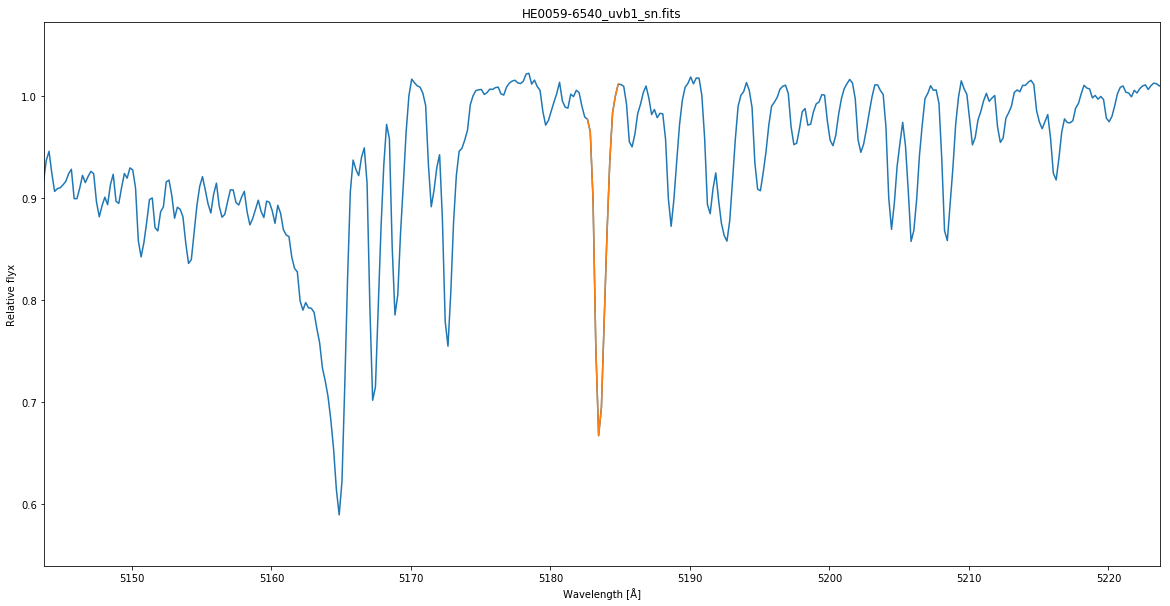

mg_triplet - Original


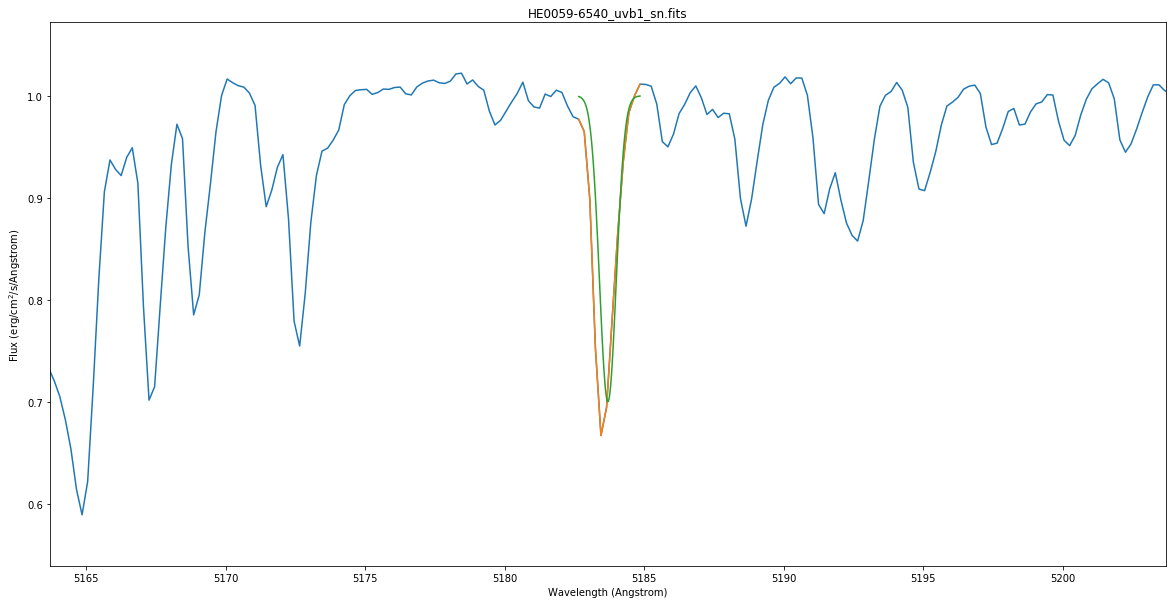

mg_triplet
Fitted gauss - range 20 Å


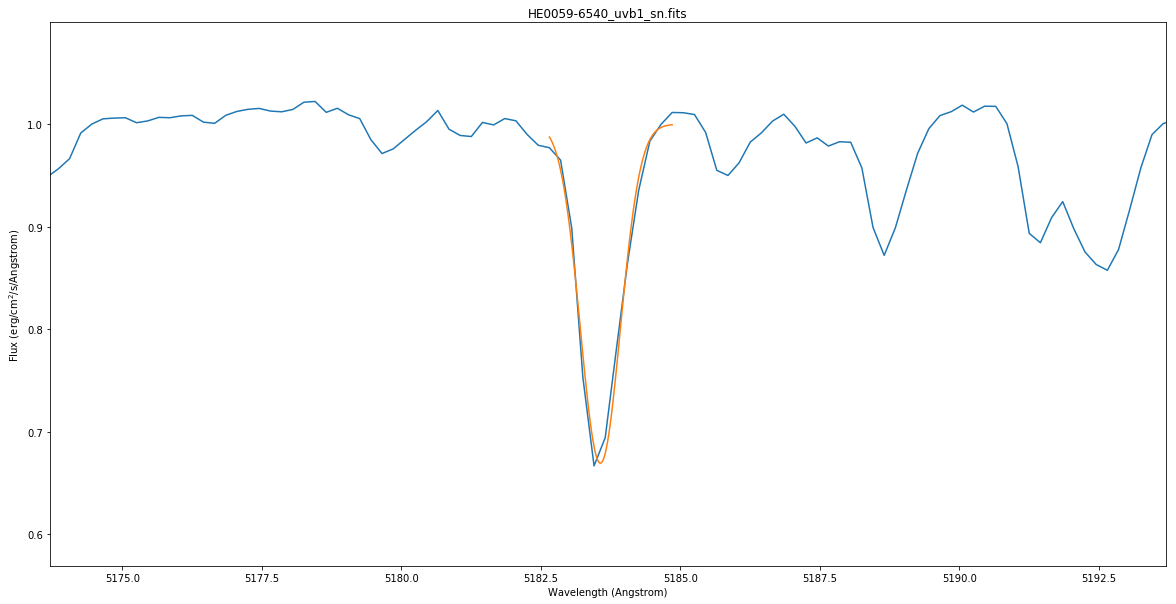

mg_triplet - Dopplershifted


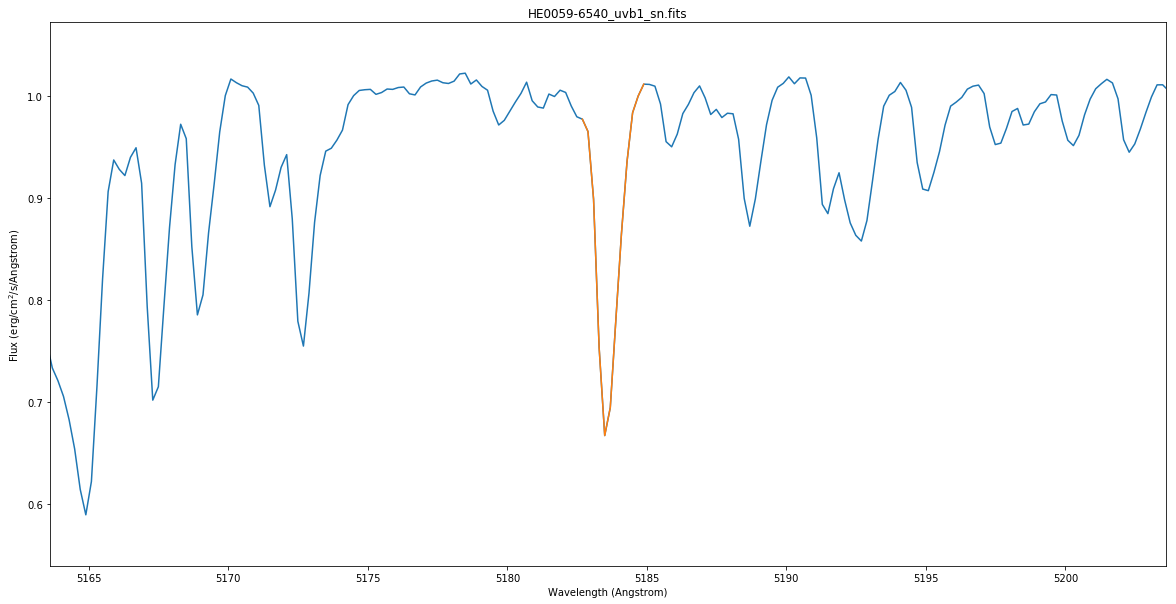

Doppler velocity: 2.2214050354781385 Km/s


In [14]:
#### Dopplershift the spectrum either by a feature from the mg triplet or the ca triplet ####

dopplershifted_wavelength, filename = doppler_velocity(
    
    # Input wavelength and flux
    filename,
    wavelength = wavelength,
    flux = flux,
    
    # Either mg_triplet or ca_triplet
    feature = 'mg_triplet',
    
    # Find the feature to dopplershift the spectrum and mark it
    # (mg_triplet: 5183.604 Å (last feature), ca_triplet: 8542.09 Å (middle feature))
    feature_wavelength = 5183.7,
    feature_min = 1.2,
    feature_max = 1.2,
    
    # Manually guess values to fit gauss
    height = 0.3,
    center = 5183.7,
    width = 0.3,
    offset= 1.0,
    
    # Weather or not to fits a gauss and dopplershifts the spectrum
    doshift = True,
    temp_continuum = 1, # Set to 1 if a normalized spectra is used
    
    # Save the velocity to a text file
    save_doppler = False
)

0.075391
0.0096277
0.172324
0.254602
0.124189
0.0795572
0.15397
0.0615088
0.0473338
0.0792122
0.142979
0.118024
0.251501
0.116187
0.0566487
0.023946
0.0110231
0.236819
0.0468355
0.0903481
0.059137
0.2622
0.158941
0.0176445
0.516896
0.0164254
0.596532
0.0219481
0.0463646
0.0557752
0.05641
0.0773951
0.016863
0.139053
0.0749717
0.221397
0.054912
0.0242601
0.183884
0.273026
0.00908917
0.0882542
0.0360154
0.148337
0.240614
0.191383
0.0139774
0.151633
0.171205
0.0313584
Spectrum with fit


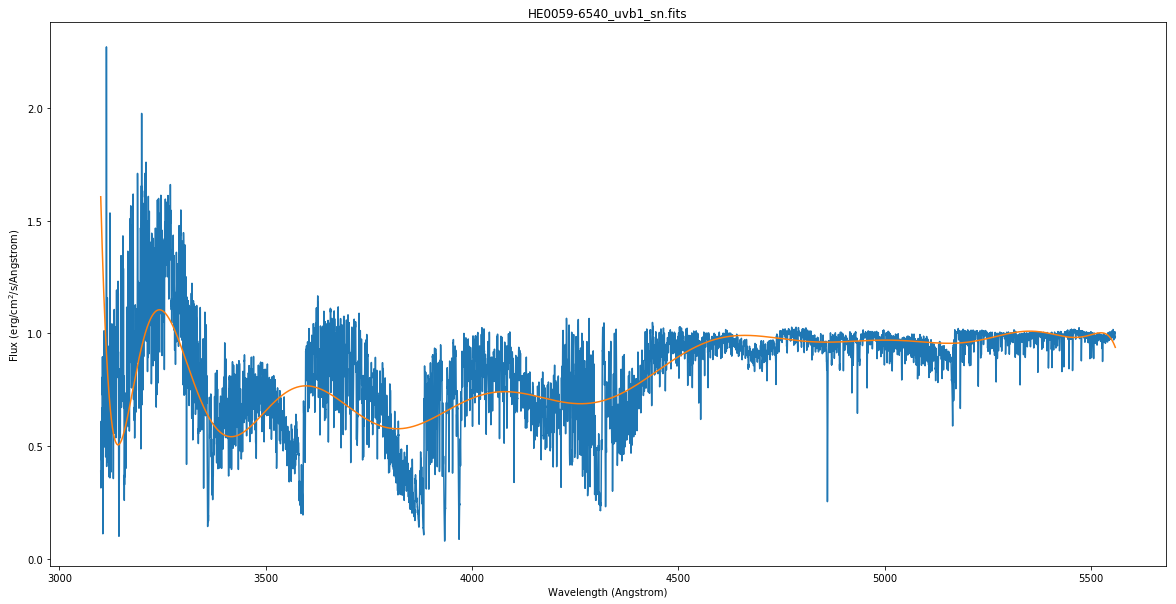

Spectrum normalized


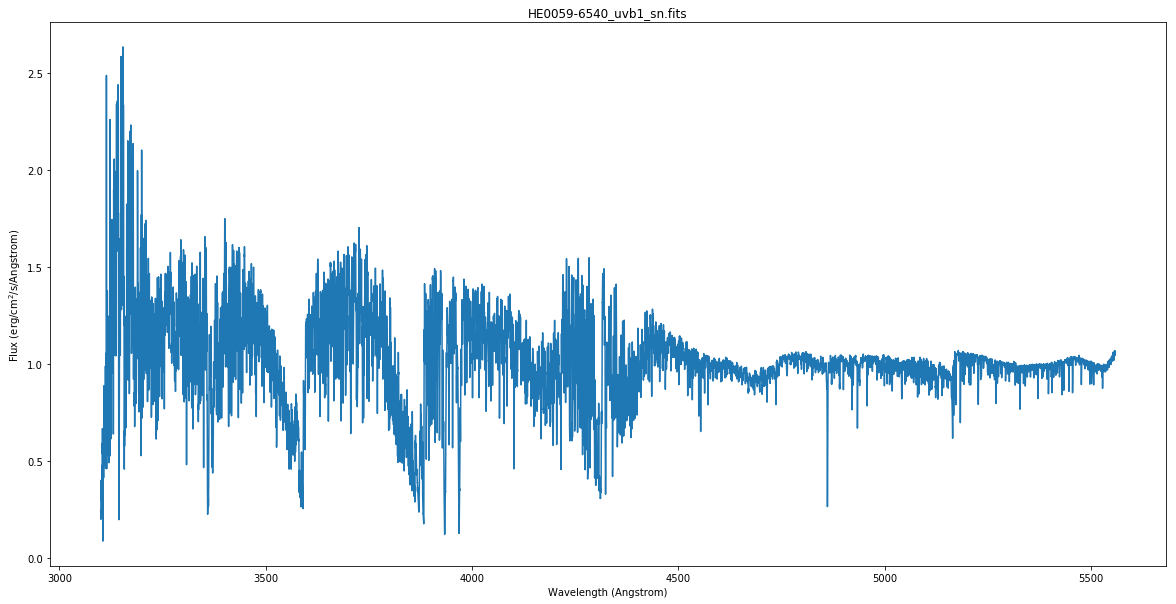

In [18]:
#### Normalize the whole spectrum or partwise ####

normalized_flux, normalized_wavelength, filename = normalize(
    
    # Choose witch wavelength and flux varible to use
    filename,
    wavelength = dopplershifted_wavelength,
    flux = flux,
    
    polynomial_degree = 15,

    
    # Optional: specify which part of the spectrum to normalize (in ångstrøm), if none, the whole spectrum is used
    wavelength_min = 3100,
    wavelength_max = None,
    flux_min = None,
    flux_max = None,
    flux_min_norm = None,
    flux_max_norm = None,
    
    
    # Prints the first 50 differences to check value to use
    print_flux_difference = True,
    
    
    # Use the difference in flux values to to fit with
    use_flux_difference = True,
    flux_difference = 0.002,
    
    
    # Define weigths for fit (interval in ångstrøm and default weigth is 1) 
    interval1 = [None,4865], weigth1 = 0., 
    interval2 = [None,5380], weigth2 = 0., 
    interval3 = [None,8700], weigth3 = 0., 
    interval4 = [None,3500], weigth4 = 0., 
    interval5 = [None,None], weigth5 = None,
    interval6 = [None,None], weigth6 = None,
    interval7 = [None,None], weigth7 = None,
    interval8 = [None,None], weigth8 = None,
    interval9 = [None,None], weigth9 = None,
    interval10 = [None,None], weigth10 = None
)

Search for feature to measure


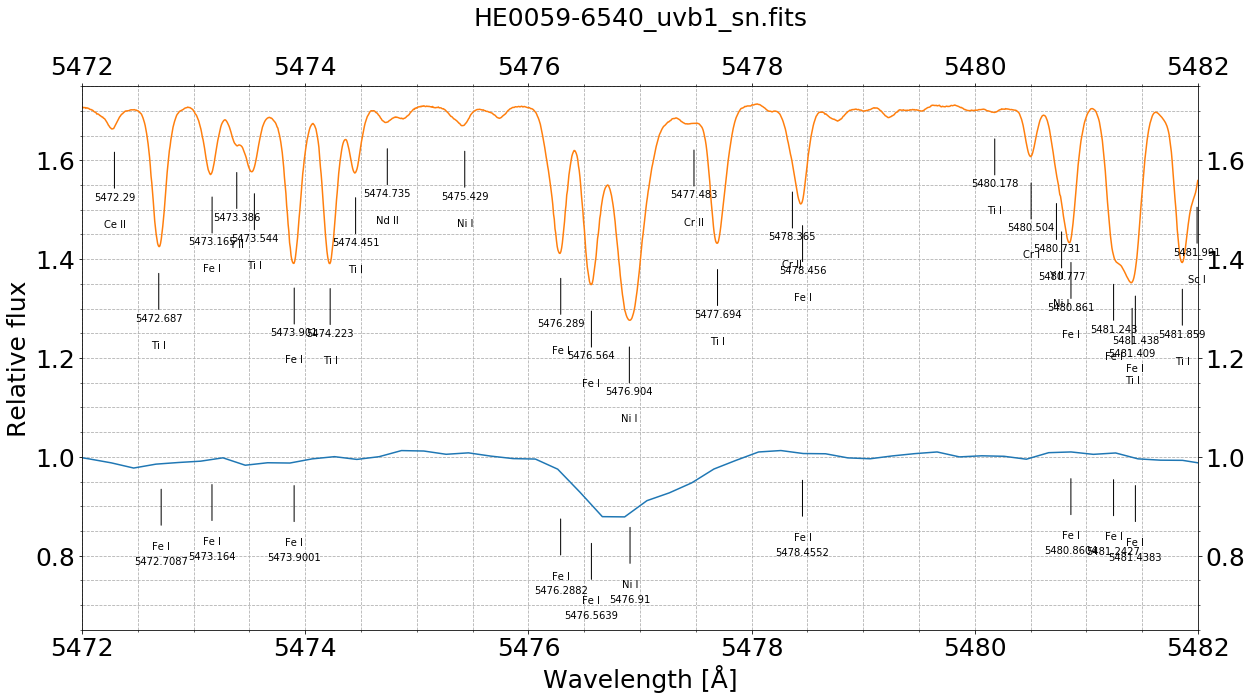

In [19]:
#### Measure equivalent widths of features ####

# Use for fast (but good!) measurements, else outcomment
NIST_line = 5477. # NIST wavelength of feature
start = NIST_line-5 # Plotting and NIST lines window
end = NIST_line+5

equivalent_width(
    
    # Input wavelength and flux
    filename,
    wavelength = dopplershifted_wavelength, 
    flux = flux,
    
    
    # Search window for finding a feature
    xmin = start,
    xmax = end, 
    ymin = 0.65, 
    ymax = 1.75,
    
    
    # Use NIST data to find features
    show_NIST_data = True,
    all_lines = False, # All lines 
    NIST_features = 'Cr Fe Ni', # 'all spectra' shows all lines available
    NIST_wavelength_min = start, 
    NIST_wavelength_max = end,
    
    # Cut off for log_gf > -4.5 and E_i < 5
    log_gf = -4.5, # Values larger then. For lines defined by 'NIST_features'.
                   # If 'None', all values accepted
    E_i = 5, # Values less then. For lines defined by 'NIST_features'. 
             # If 'None', all values accepted
    
    
    # Plot Acturus and/or sun spectrum
    plot_arcturus = True,
    plot_sun = False,
    
    
    # Use to measure a features width in ångstrom
    measure_line = False,
    center_wavelength = NIST_line, # Features center wavelength
    wavelength_span = 1., # Plots a measurement with a ångstrøm width of

    
    # Use to filter displayed features, such that only features separated by some ångstrøm are displayed
    feature_separation = False, # Only display features which are separated by some ångstrom
    separation_distance = 0.5, # Feature separation distance larger then. In ångstrøm
    log_gf_other = -1.5, # Values larger then. For all other lines then what is defined by 'NIST_features'.
    E_i_other = 3, # Values less then. For all other lines then what is defined by 'NIST_features'.

    
    # Print lines found
    print_lines = False,
    
    
    # Mark the feature, remember ion specification.
    mark_feature = False,
    element = 'Mg', 
    feature_wavelength = NIST_line, # Should be set to the elements precise wavelength from NIST 
    feature_min = 2., 
    feature_max = 2.,

    
    # Guess values for a gaussian fit
    guess_fit = False,
    offset = 0.92, # Fixes the continuum level in both the guessed and fitted gaussian
    height1 = 0.4, center1 = NIST_line, width1 = 0.3,
    height2 = 0.5, center2 = NIST_line+1.5, width2 = 0.3,
    height3 = 0.6, center3 = NIST_line+4., width3 = 0.3, 
    height4 = None, center4 = 6118., width4 = 0.3,
    
     
    # With the guessed values, fit a gaussian
    fit_gauss = False,
    notes = '', # Add a note to the measured feature
    save_EW = False # Saves the equivalent width and creates a ASCII file in order to reproduce result
       
)

In [183]:
#### Save any wavelength and flux variable to a text file ####

ASCII_wavelength_flux(
    
    # Specify which wavelength and flux varible to use
    wavelength = normalized_wavelength, 
    flux = normalized_flux,
    
    # Specify which element, where it's located and how large a range in ångstrøm.
    element = '',
    feature_wavelength = None,
    wavelength_range = None,
    
    # If no specific element or range then choose any wavelengths
    wavelength_min = 4750,
    wavelength_max = 5300
)


In [133]:
#### Check the measured elements ####

wavelength_check, flux_check, filename = plot_check(    
    
    # Use variables to check spectrum
    filename = '1234',
    use_variable = False,
    wavelength = None,
    flux = None,
    wavelength_min = None,
    wavelength_max = None,
    flux_min = None,
    flux_max = None,
    
    # Print files
    print_files = True,
    # Pick a file
    file_number = 1,
    # Plot file
    plot = True,
    plot_acturus = False,
    
    
    # Plot gauss from data to reproduce result
    plot_gauss = False,
    continuum_feature = None,
    FWHM_feature = None,
    flux_feature = None,
    wavelength_mean_feature = None,
    
    
    # Plot window options
    flux_min_feature = None,
    flux_max_feature = None,
    wavelength_min_feature = None,
    wavelength_max_feature = None
)

0 : HE0058-3449uv_snor_equivalent_widths.txt
1 : HE0206-1916uv_snor_equivalent_widths.txt
2 : HE0241-3512uv_snor_equivalent_widths.txt
3 : HE0400-2030uv_snor_equivalent_widths.txt
4 : HE0408-1733uv_snor_equivalent_widths.txt
5 : HE0414-0343uv_snor_equivalent_widths.txt
6 : HE0430-1609uv_snor_equivalent_widths.txt
7 : HE0430-4901uv_snor_equivalent_widths.txt
8 : HE0448-4806uv_snor_equivalent_widths.txt
9 : HE0516-2515uv_snor_equivalent_widths.txt
10 : HE1315-2035uv_snor_equivalent_widths.txt
11 : HE1430-0919uv_snor_equivalent_widths.txt
12 : HE1431-0245uv_snor_equivalent_widths.txt
13 : HE2138-1616uv_snor_equivalent_widths.txt
14 : HE2141-1441uv_snor_equivalent_widths.txt
15 : HE2144-1832uv_snor_equivalent_widths.txt
16 : HE2153-2323uv_snor_equivalent_widths.txt
17 : HE2235-5058uv_snor_equivalent_widths.txt
18 : HE2250-4229uv_snor_equivalent_widths.txt
19 : HE2310-4523uv_snor_equivalent_widths.txt
20 : HE2319-5228uv_snor_equivalent_widths.txt
21 : HE2357-2718uv_snor_equivalent_widths.tx

ValueError: could not convert string to float: b'2018/02/02'